**Student number**| **Student name**
-|-
20221643| Rafael Dinis
20220726| Sabeen Mubashar
20221396| Stanislav Slesarev
20220663| Aidar Zaripov


This notebook is better to be viewed in Colab, because it contains many sections and it is more convenient to collapse and expand the section there.

# Initialization

In [ ]:
# This will install the language detection, transaltaion, contractions, emoji, transformers, nltk, torch libraries if you don't have them
!pip install langdetect
!pip install emoji
!pip install demoji
!pip install translate
!pip install googletrans
!pip install contractions
!pip install torch
!pip install transformers
!pip install nltk
!pip install gensim
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=6d2d45d3f86206c2a903a943132e0aadfab593dba43079cf5dbd5378b6bbfb26
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.3/356.3 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.1-py2.py3-none-any.whl size=351210 sha256=2e51d59ad13c513c29702dd86fe533d14293fbd1f3dd543db2f12c654727bb31
  Stored in directory: /root/.cache/pip/wheels/51/92/44/e2ef13f803aa08711819357e6de0c5fe67b874671141413565
Su

In [ ]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import re
import regex
import emoji
import demoji
import nltk
import googletrans
import contractions
import string
import torch
import requests
import zipfile
import gensim.downloader
import pickle
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Masking, Input
from tensorflow.keras import layers
from tensorflow import keras

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from itertools import product
from google.colab import drive, files
from langdetect import detect, lang_detect_exception
from textblob import TextBlob
from googletrans import Translator
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from tqdm import tqdm


demoji.download_codes()
nltk.download('stopwords')  # Download the stopwords corpus
nltk.download('rslp')
nltk.download('wordnet')
nltk.download('punkt') # Needed for Word frequency bar charts

%matplotlib inline

# for better resolution plots
%config InlineBackend.figure_format = 'retina'

# Seting seaborn style
sns.set()

<ipython-input-2-124f3b7d1ef9>:59: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Making the files available for Gdrive
# Run this only if you work in Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading the data

In [ ]:
# Loading training data
train = pd.read_excel("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/train.xlsx")
test = pd.read_excel("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/test.xlsx")
train_reviews = pd.read_excel("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/train_reviews.xlsx")
test_reviews = pd.read_excel("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/test_reviews.xlsx")

# Data exploration and preprocessing

## Just some auxiliary functions for data exploration

In [ ]:
# This is just to ensure that all the functions work with no issue futher (as many require strictly only strings as an input)

def all_to_string():
    train['description'] = train['description'].astype(str)
    train['host_about'] = train['host_about'].astype(str)
    train_reviews['comments'] = train_reviews['comments'].astype(str)

    test['description'] = test['description'].astype(str)
    test['host_about'] = test['host_about'].astype(str)
    test_reviews['comments'] = test_reviews['comments'].astype(str)

all_to_string()

In [ ]:
# Functions for easy checking how the feature is related to the target variable and checking the distribution

def stat_sample_with_unlisted(df, col):
    total_count = df['index'].count()
    group_count = df.groupby(col)['index'].count()
    group_percentage = (group_count / total_count)*100
    unlisted_sum = df.groupby(col)["unlisted"].sum()
    unlisted_rate = (unlisted_sum / group_count).round(3)
    result_df = pd.concat([group_count.rename("cnt"), group_percentage.rename("percentage").round(2),
                           unlisted_sum.rename("sum unlisted"), unlisted_rate.rename("unlisted rate")],
                          axis=1)
    return result_df

def stat_sample(df, col):
    total_count = df['index'].count()
    group_count = df.groupby(col)['index'].count()
    group_percentage = (group_count / total_count)*100
    result_df = pd.concat([group_count.rename("cnt"), group_percentage.rename("percentage").round(2)], axis=1)
    return result_df

## Basic exploration

In [ ]:
train.tail(2)

index                                        description  \
12494  12495  A Terra da Eira é uma casa de campo rodeada de...   
12495  12496  This brandnew Apartment combines elegant charm...   

                                              host_about  unlisted  
12494  Somos uma familia de 5. Gostamos de viajar e d...         1  
12495  We are a German-Portuguese couple with a Passi...         1

In [ ]:
train_reviews.tail(2)

index                                           comments
721400  12494  We had a lovely stay at this apartment. Sofia ...
721401  12494  Clean, very good position, easy checkin, the p...

In [ ]:
test.tail(2)

index                                        description  \
1387   1388  The apartment in Lisbon  has capacity for 2 pe...   
1388   1389  Appartement situé à 5 minutes à pieds du magni...   

                                             host_about  
1387  We are Feels Like Home Holiday Rentals.\nA com...  
1388                                  Franco-Autrichien

In [ ]:
test_reviews.tail(2)

index                                           comments
80875   1388  Unfortunately not a pleasant experience. The h...
80876   1388  Hi everybody!<br/>If you want to live with coc...

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12496 entries, 0 to 12495
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        12496 non-null  int64 
 1   description  12496 non-null  object
 2   host_about   12496 non-null  object
 3   unlisted     12496 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 390.6+ KB


In [ ]:
train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721402 entries, 0 to 721401
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     721402 non-null  int64 
 1   comments  721402 non-null  object
dtypes: int64(1), object(1)
memory usage: 11.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1389 entries, 0 to 1388
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        1389 non-null   int64 
 1   description  1389 non-null   object
 2   host_about   1389 non-null   object
dtypes: int64(1), object(2)
memory usage: 32.7+ KB


In [ ]:
test_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80877 entries, 0 to 80876
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     80877 non-null  int64 
 1   comments  80877 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


All the columns are non-null. The only raw column we can show distribution of is **unlisted**.

In [ ]:
# Count the occurrences of each value in unlisted
unlisted_counts = train['unlisted'].value_counts()
pd.DataFrame({'Cnt': unlisted_counts.values, 'Percentage': (unlisted_counts / unlisted_counts.sum()).round(3)})

Cnt  Percentage
0  9033       0.723
1  3463       0.277

The classes of our target variable are imbalanced, about 28% of the listings were unlisted

## Deduplication checks

In [ ]:
# Checking are there any duplicates by the index in the listings table (index in reviews should have duplicates just by logic)

train.duplicated(subset=['index']).sum()

0

In [ ]:
# Checking are there any duplicates by the description and host name in the listings table

train.duplicated(subset=['description', 'host_about']).sum()

642

In [ ]:
# Find the duplicated rows based on 'description' and 'host_about'
duplicates_mask = train.duplicated(subset=['description', 'host_about'], keep=False)

# Filter the DataFrame based on the duplicates mask
duplicated_df = train[duplicates_mask].sort_values("description")

duplicated_df

index                                        description  \
10978  10979  "Are you really ready to feel like a local?" S...   
8450    8451  "Are you really ready to feel like a local?" S...   
4487    4488  "Are you really ready to feel like a local?" S...   
1935    1936  #FRIENDS WHO HAVEN'T MET YET! <br /><br />We t...   
1967    1968  #FRIENDS WHO HAVEN'T MET YET! <br /><br />We t...   
...      ...                                                ...   
480      481  入住独一无二的房源，感受市中心的律动。<br /><br /><b>License numb...   
11803  11804  入住这处在这处适合家庭入住的房源与亲朋好友重聚。Hello.Our apartment is...   
11652  11653  入住这处在这处适合家庭入住的房源与亲朋好友重聚。Hello.Our apartment is...   
1666    1667  ￫ Charming apartment perfectly located walking...   
2943    2944  ￫ Charming apartment perfectly located walking...   

                                              host_about  unlisted  
10978  Eternal in love for lisbon_x000D_\nMy pleasure...         0  
8450   Eternal in love for lisbon_x000D_\nMy pleasure...         0  
4487   Eternal in love for lisbon_x000D_\nMy pleasure...         0  
1935   hi everyone\nJust a 22 year old making new fri...         0  
1967   hi everyone\nJust a 22 year old making new fri...         0  
...                                                  ...       ...  
480    Welcome to LX History Hotel in Lisbon, Portuga...         1  
11803               大家好！我是苏珊娜，很高兴和您分享我的房源，广交世界各地的朋友。\n\n         1  
11652               大家好！我是苏珊娜，很高兴和您分享我的房源，广交世界各地的朋友。\n\n         1  
1666   I am an interior designer, plant lover, and wo...         1  
2943   I am an interior designer, plant lover, and wo...         1  

[996 rows x 4 columns]

In [ ]:
# Let's see whether "duplicated" listings have the same reviews or not
duplicated_df.merge(train_reviews, on='index', how='left').sort_values("host_about")

index                                        description host_about  \
21385   8553  Room with private bathroom and air conditionin...       \n\n   
21383   8553  Room with private bathroom and air conditionin...       \n\n   
21382   8553  Room with private bathroom and air conditionin...       \n\n   
21381   2815  Room with private bathroom and air conditionin...       \n\n   
21380   2815  Room with private bathroom and air conditionin...       \n\n   
...      ...                                                ...        ...   
1756    1216                <b>License number</b><br />81309/AL      超级三脚猫   
1757    1216                <b>License number</b><br />81309/AL      超级三脚猫   
1758    1216                <b>License number</b><br />81309/AL      超级三脚猫   
1744   10352                <b>License number</b><br />81309/AL      超级三脚猫   
1732   10317                <b>License number</b><br />81309/AL      超级三脚猫   

       unlisted                                           comments  
21385         0  Man kann es nur weiter empfehlen. Es ist der b...  
21383         0                                   Very Nice people  
21382         0  Good house. Great communication. Great host! R...  
21381         0  Mijn gasten en ik hadden een geweldig verblijf...  
21380         0                                         Все хорошо  
...         ...                                                ...  
1756          0  Place in very good spot when spending time in ...  
1757          0          propriétaire super sympa , très réactive.  
1758          0                                               Good  
1744          0  A very cool apartment in a great location in t...  
1732          0  O apartamento fica próximo à muitos pontos tur...  

[29046 rows x 5 columns]

Looking at the result table row by row one can notice that actually the "duplicated" listings (having the same description and host_about) seem to be actually different listings as they have different reviews. So at the end no any duplicates treatment was made for the dataset

## Data cleansing and creating auxiliary variables

### HTML tags treatment

In [ ]:
# There are many html tags in all the text fields, better to remove all of them (replace with space to prevent unnecessary merging the words)

def replace_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    has_html_tag = bool(soup.find())
    cleaned_text = soup.get_text(separator=' ')
    return cleaned_text, has_html_tag

In [ ]:
# Removing html tags from all the text fields in the listings and comments while creating a column denoting that the text contained HTML tags
train[['description', 'descriptionHasHTMLTag']] = train['description'].apply(replace_html_tags).apply(pd.Series)
train[['host_about', 'host_aboutHasHTMLTag']] = train['host_about'].apply(replace_html_tags).apply(pd.Series)
train_reviews[['comments', 'commentsHasHTMLTag']] = train_reviews['comments'].astype(str).apply(replace_html_tags).apply(pd.Series)

test[['description', 'descriptionHasHTMLTag']] = test['description'].apply(replace_html_tags).apply(pd.Series)
test[['host_about', 'host_aboutHasHTMLTag']] = test['host_about'].apply(replace_html_tags).apply(pd.Series)
test_reviews[['comments', 'commentsHasHTMLTag']] = test_reviews['comments'].astype(str).apply(replace_html_tags).apply(pd.Series)

<ipython-input-20-3f443a76095f>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
<ipython-input-20-3f443a76095f>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
<ipython-input-20-3f443a76095f>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
<ipython-input-20-3f443a76095f>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
<ipython-input-20-3f443a76095f>:4: MarkupResemblesLocato

In [ ]:
# There are still some <br, <b, </br, </b, </ or < (< only at the end of the string) tags left in the description (apparently the text was cropped as this is not a full HTML tag, but just part of it)
# This applies only to the description column as all others don't have this issue

train['descriptionHasBrokenHTMLtag'] = train['description'].str.contains(r'<br|<b|<\/br|<\/b|<\/|<\s*$', case=False, regex=True)

train['description'] = train['description'].str.replace(r'<br|<b|<\/br|<\/b|<\/|<\s*$', ' ', case=False, regex=True)
test['description'] = test['description'].str.replace(r'<br|<b|<\/br|<\/b|<\/|<\s*$', ' ', case=False, regex=True)

In [ ]:
stat_sample_with_unlisted(train,['descriptionHasHTMLTag', 'descriptionHasBrokenHTMLtag'])

cnt  percentage  \
descriptionHasHTMLTag descriptionHasBrokenHTMLtag                      
False                 False                          106        0.85   
True                  False                        11752       94.05   
                      True                           638        5.11   

                                                   sum unlisted  unlisted rate  
descriptionHasHTMLTag descriptionHasBrokenHTMLtag                               
False                 False                                  30          0.283  
True                  False                                3282          0.279  
                      True                                  151          0.237

In [ ]:
stat_sample_with_unlisted(train,['host_aboutHasHTMLTag'])

cnt  percentage  sum unlisted  unlisted rate
host_aboutHasHTMLTag                                                
False                 12494       99.98          3463          0.277
True                      2        0.02             0          0.000

In [ ]:
stat_sample(train_reviews,['commentsHasHTMLTag'])

cnt  percentage
commentsHasHTMLTag                    
False               537735       74.54
True                183667       25.46

Reviews had a lot of HTML tags, while there were not so common in the the listings (description and host_about). HTML tag is a weak predictor (no statistically significant difference in unlisted rate between groups)

### Treatment of URLs

In [ ]:
# Function for removing URLs and creating a variable denoting that the URL was removed
def remove_urls(text):
    url_pattern = r'(?:^|\s)((?:ftp|http[s]?):\/\/(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?)|www\.[\w_-]+(?:(?:\.[\w_-]+)+)(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    has_url = bool(re.search(url_pattern, text))
    cleaned_text = re.sub(url_pattern, ' ', text)
    return cleaned_text, has_url

In [ ]:
# Removing URLs (replacing them with space)
train[['description', 'descriptionHas_url']] = train['description'].apply(remove_urls).apply(pd.Series)
train[['host_about', 'host_aboutHas_url']] = train['host_about'].apply(remove_urls).apply(pd.Series)
train_reviews[['comments', 'commentsHas_url']] = train_reviews['comments'].apply(remove_urls).apply(pd.Series)

test[['description', 'descriptionHas_url']] = test['description'].apply(remove_urls).apply(pd.Series)
test[['host_about', 'host_aboutHas_url']] = test['host_about'].apply(remove_urls).apply(pd.Series)
test_reviews[['comments', 'commentsHas_url']] = test_reviews['comments'].apply(remove_urls).apply(pd.Series)

In [ ]:
stat_sample_with_unlisted(train,['descriptionHas_url', 'host_aboutHas_url'])

cnt  percentage  sum unlisted  \
descriptionHas_url host_aboutHas_url                                    
False              False              12361       98.92          3412   
                   True                  84        0.67            45   
True               False                 49        0.39             6   
                   True                   2        0.02             0   

                                      unlisted rate  
descriptionHas_url host_aboutHas_url                 
False              False                      0.276  
                   True                       0.536  
True               False                      0.122  
                   True                       0.000

In [ ]:
stat_sample(train_reviews,['commentsHas_url'])

cnt  percentage
commentsHas_url                    
False            721323       99.99
True                 79        0.01

99% of the listings don't show presense of URL in the text. As such this won't be a very strong predictor as well so this variable can be ignored

### Treatment of special symbols

In [ ]:
# Create a new column indicating presence of '_x000D_' (line break) for the listings
train['descriptionHas_x000D'] = train['description'].str.contains('_x000D_')
train['host_aboutHas_x000D'] = train['host_about'].str.contains('_x000D_')
train_reviews['commentsHas_x000D'] = train_reviews['comments'].str.contains('_x000D_')

test['descriptionHas_x000D'] = test['description'].str.contains('_x000D_')
test['host_aboutHas_x000D'] = test['host_about'].str.contains('_x000D_')
test_reviews['commentsHas_x000D'] = test_reviews['comments'].str.contains('_x000D_')

# Replace '_x000D_' with a space
train['description'] = train['description'].str.replace('_x000D_', ' ')
train['host_about'] = train['host_about'].str.replace('_x000D_', ' ')
train_reviews['comments'] = train_reviews['comments'].str.replace('_x000D_', ' ')

test['description'] = test['description'].str.replace('_x000D_', ' ')
test['host_about'] = test['host_about'].str.replace('_x000D_', ' ')
test_reviews['comments'] = test_reviews['comments'].str.replace('_x000D_', ' ')

In [ ]:
stat_sample_with_unlisted(train,['descriptionHas_x000D', 'host_aboutHas_x000D'])

cnt  percentage  sum unlisted  \
descriptionHas_x000D host_aboutHas_x000D                                   
False                False                8429       67.45          2747   
                     True                 4067       32.55           716   

                                          unlisted rate  
descriptionHas_x000D host_aboutHas_x000D                 
False                False                        0.326  
                     True                         0.176

host_aboutHas_x000D is surprisinly quite strong predictor for unlisted event

In [ ]:
stat_sample(train_reviews,['commentsHas_x000D'])

cnt  percentage
commentsHas_x000D                    
False              690586       95.73
True                30816        4.27

### Treatment of Special Text Patterns (License number)

In [ ]:
# Function to remove the "License number XXXXX" and "License number exempt" pattern and create a new columns 'contained_pattern'


def remove_license_exemption(text):
    pattern = r"License number exempt"
    contained_pattern = bool(re.search(pattern, text, flags=re.IGNORECASE))
    text = re.sub(pattern, ' ', text, flags=re.IGNORECASE)
    return text.strip(), contained_pattern

def remove_license_pattern(text):
    pattern = r"License number \d+/AL|License number \d+AL|License number \d+-AL|License number AL/\d+|License number \d+/\d+|License number \d+|\d+/AL"
    contained_pattern = bool(re.search(pattern, text, flags=re.IGNORECASE))
    text = re.sub(pattern, ' ', text, flags=re.IGNORECASE)
    return text, contained_pattern

In [ ]:
# Apply the 'remove_license_pattern' function to the 'description' column (other)
train['description'], train['descriptionHas_license_exempt'] = zip(*train['description'].map(remove_license_exemption))
train['description'], train['descriptionHas_license_number'] = zip(*train['description'].map(remove_license_pattern))

test['description'], test['descriptionHas_license_exempt'] = zip(*test['description'].map(remove_license_exemption))
test['description'], test['descriptionHas_license_number'] = zip(*test['description'].map(remove_license_pattern))

In [ ]:
stat_sample_with_unlisted(train,['descriptionHas_license_exempt', 'descriptionHas_license_number'])

cnt  percentage  \
descriptionHas_license_exempt descriptionHas_license_number                     
False                         False                          7738       61.92   
                              True                           4089       32.72   
True                          False                           669        5.35   

                                                             sum unlisted  \
descriptionHas_license_exempt descriptionHas_license_number                 
False                         False                                  1899   
                              True                                   1199   
True                          False                                   365   

                                                             unlisted rate  
descriptionHas_license_exempt descriptionHas_license_number                 
False                         False                                  0.245  
                              True                                   0.293  
True                          False                                  0.546

### Treatments of emoticons

In [ ]:
# Function for detecting emoticons while creating a variable denoting that the text had an emoticon

def remove_emoticons(text):
    emoticon_pattern = r'(?::|;|=)(?:-)?(?:\)|\(|D|P|O|\\|\/|\||\]|\[|3|>|<|})'
    has_emoticon = bool(re.search(emoticon_pattern, text))
    cleaned_text = re.sub(emoticon_pattern, ' ', text)
    return cleaned_text.strip(), has_emoticon

In [ ]:
# Removing emoticons and creating a column denoting that the text contains emoticons
all_to_string()

train[['description', 'descriptionHas_emoticon']] = train['description'].apply(remove_emoticons).apply(pd.Series)
train[['host_about', 'host_aboutHas_emoticon']] = train['host_about'].apply(remove_emoticons).apply(pd.Series)
train_reviews[['comments', 'commentsHas_emoticon']] = train_reviews['comments'].apply(remove_emoticons).apply(pd.Series)

test[['description', 'descriptionHas_emoticon']] = test['description'].apply(remove_emoticons).apply(pd.Series)
test[['host_about', 'host_aboutHas_emoticon']] = test['host_about'].apply(remove_emoticons).apply(pd.Series)
test_reviews[['comments', 'commentsHas_emoticon']] = test_reviews['comments'].apply(remove_emoticons).apply(pd.Series)

In [ ]:
stat_sample_with_unlisted(train,['descriptionHas_emoticon', 'host_aboutHas_emoticon'])

cnt  percentage  \
descriptionHas_emoticon host_aboutHas_emoticon                      
False                   False                   10910       87.31   
                        True                     1151        9.21   
True                    False                     301        2.41   
                        True                      134        1.07   

                                                sum unlisted  unlisted rate  
descriptionHas_emoticon host_aboutHas_emoticon                               
False                   False                           3068          0.281  
                        True                             275          0.239  
True                    False                             80          0.266  
                        True                              40          0.299

In [ ]:
stat_sample(train_reviews,['commentsHas_emoticon'])

cnt  percentage
commentsHas_emoticon                    
False                 684629        94.9
True                   36773         5.1

### Treatment of emojis, dingbats and miscellaneous symbols

In [ ]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"  # miscellaneous symbols
                            #  u"\U000024C2-\U0001F251"  # enclosed characters (this one caused removal of chinese, so we don't include it)
                               u"\u2190-\u21FF"          # arrows
                               u"\u25A0-\u25FF"          # geometric shapes
                            #   u"\u2000-\u206F"          # general punctuation (will remove punctuation later after contractions expansion)
                            #   u"\u20A0-\u20CF"          # currency symbols (will remove separately)
                               u"\u2100-\u214F"          # letterlike symbols
                               u"\u2300-\u23FF"          # miscellaneous technical
                               u"\u2600-\u26FF"          # miscellaneous symbols
                                u"\u2700-\u27BF"          # dingbats
                            #   u"\u3000-\u303F"          # CJK symbols and punctuation (these are Chinese characters)
                            #   u"\uFF00-\uFFEF"          # full-width Latin characters (these are Latin used in Chinese)
                               "]+", flags=re.UNICODE)

    has_emoji = bool(emoji_pattern.search(text))
    cleaned_text = emoji_pattern.sub(' ', text)
    return cleaned_text.strip(), has_emoji

In [ ]:
# Removing emojis and creating a column denoting that the text contains emojis
all_to_string()
train['description'], train['descriptionHas_emoji'] = zip(*train['description'].apply(remove_emojis))
train['host_about'], train['host_aboutHas_emoji'] = zip(*train['host_about'].apply(remove_emojis))
train_reviews['comments'], train_reviews['commentsHas_emoji'] = zip(*train_reviews['comments'].apply(remove_emojis))

test['description'], test['descriptionHas_emoji'] = zip(*test['description'].apply(remove_emojis))
test['host_about'], test['host_aboutHas_emoji'] = zip(*test['host_about'].apply(remove_emojis))
test_reviews['comments'], test_reviews['commentsHas_emoji'] = zip(*test_reviews['comments'].apply(remove_emojis))

In [ ]:
stat_sample_with_unlisted(train,['descriptionHas_emoji', 'host_aboutHas_emoji'])

cnt  percentage  sum unlisted  \
descriptionHas_emoji host_aboutHas_emoji                                    
False                False                12347       98.81          3416   
                     True                     2        0.02             1   
True                 False                  147        1.18            46   

                                          unlisted rate  
descriptionHas_emoji host_aboutHas_emoji                 
False                False                        0.277  
                     True                         0.500  
True                 False                        0.313

In [ ]:
stat_sample(train_reviews,['commentsHas_emoji'])

cnt  percentage
commentsHas_emoji                    
False              708747       98.25
True                12655        1.75

### Treatment of currency signs

In [ ]:
def remove_currency(text):
    emoji_pattern = re.compile("["
                               u"\u20A0-\u20CF"          # currency symbols
                               "]+", flags=re.UNICODE)

    has_emoji = bool(emoji_pattern.search(text))
    cleaned_text = emoji_pattern.sub(' ', text)
    return cleaned_text.strip(), has_emoji

In [ ]:
# Removing emojis and creating a column denoting that the text contains emojis
all_to_string()
train['description'], train['descriptionHas_currency'] = zip(*train['description'].apply(remove_currency))
train['host_about'], train['host_aboutHas_currency'] = zip(*train['host_about'].apply(remove_currency))
train_reviews['comments'], train_reviews['commentsHas_currency'] = zip(*train_reviews['comments'].apply(remove_currency))

test['description'], test['descriptionHas_currency'] = zip(*test['description'].apply(remove_currency))
test['host_about'], test['host_aboutHas_currency'] = zip(*test['host_about'].apply(remove_currency))
test_reviews['comments'], test_reviews['commentsHas_currency'] = zip(*test_reviews['comments'].apply(remove_currency))

In [ ]:
stat_sample_with_unlisted(train,['descriptionHas_currency', 'host_aboutHas_currency'])

cnt  percentage  \
descriptionHas_currency host_aboutHas_currency                      
False                   False                   11893       95.17   
True                    False                     603        4.83   

                                                sum unlisted  unlisted rate  
descriptionHas_currency host_aboutHas_currency                               
False                   False                           3331          0.280  
True                    False                            132          0.219

In [ ]:
stat_sample(train_reviews,['commentsHas_currency'])

cnt  percentage
commentsHas_currency                    
False                 718465       99.59
True                    2937        0.41

### Treatment of numbers

In [ ]:
# Count number of times any number occurs in the string

train['descriptionNumberCount'] = train['description'].apply(lambda text: len(re.findall(r'\d+', text)))
train['host_aboutNumberCount'] = train['host_about'].apply(lambda text: len(re.findall(r'\d+', text)))
train_reviews['commentsNumberCount'] = train_reviews['comments'].apply(lambda text: len(re.findall(r'\d+', text)))

test['descriptionNumberCount'] = test['description'].apply(lambda text: len(re.findall(r'\d+', text)))
test['host_aboutNumberCount'] = test['host_about'].apply(lambda text: len(re.findall(r'\d+', text)))
test_reviews['commentsNumberCount'] = test_reviews['comments'].apply(lambda text: len(re.findall(r'\d+', text)))

In [ ]:
# Removing numbers

train['description'] = train['description'].str.replace('\d+', ' ', regex=True)
train['host_about'] = train['host_about'].str.replace('\d+', ' ', regex=True)
train_reviews['comments'] = train_reviews['comments'].str.replace('\d+', ' ', regex=True)

test['description'] = test['description'].str.replace('\d+', ' ', regex=True)
test['host_about'] = test['host_about'].str.replace('\d+', ' ', regex=True)
test_reviews['comments'] = test_reviews['comments'].str.replace('\d+', ' ', regex=True)

In [ ]:
stat_sample_with_unlisted(train,['descriptionNumberCount'])

cnt  percentage  sum unlisted  unlisted rate
descriptionNumberCount                                               
0                       2086       16.69           713          0.342
1                       1855       14.84           541          0.292
2                       1735       13.88           469          0.270
3                       1466       11.73           387          0.264
4                       1272       10.18           346          0.272
5                        922        7.38           197          0.214
6                        792        6.34           205          0.259
7                        474        3.79           134          0.283
8                        498        3.99           108          0.217
9                        345        2.76            86          0.249
10                       236        1.89            53          0.225
11                       168        1.34            42          0.250
12                       133        1.06            25          0.188
13                       144        1.15            30          0.208
14                        70        0.56            14          0.200
15                        58        0.46            13          0.224
16                        46        0.37            15          0.326
17                        38        0.30            20          0.526
18                        24        0.19            11          0.458
19                        19        0.15             9          0.474
20                        19        0.15            11          0.579
21                        24        0.19             5          0.208
22                        29        0.23            10          0.345
23                        18        0.14            10          0.556
24                         9        0.07             4          0.444
25                         7        0.06             2          0.286
26                         5        0.04             1          0.200
27                         1        0.01             1          1.000
28                         2        0.02             1          0.500
39                         1        0.01             0          0.000

In [ ]:
stat_sample_with_unlisted(train,['host_aboutNumberCount'])

cnt  percentage  sum unlisted  unlisted rate
host_aboutNumberCount                                               
0                      8237       65.92          2263          0.275
1                      2520       20.17           744          0.295
2                       992        7.94           285          0.287
3                       300        2.40            74          0.247
4                       174        1.39            39          0.224
5                        90        0.72            10          0.111
6                       116        0.93            31          0.267
7                        27        0.22            13          0.481
8                         5        0.04             1          0.200
9                         4        0.03             1          0.250
11                        1        0.01             1          1.000
12                        3        0.02             0          0.000
13                        4        0.03             1          0.250
14                       17        0.14             0          0.000
15                        4        0.03             0          0.000
17                        1        0.01             0          0.000
20                        1        0.01             0          0.000

In [ ]:
stat_sample(train_reviews,['commentsNumberCount'])

cnt  percentage
commentsNumberCount                    
0                    568500       78.80
1                     91887       12.74
2                     35274        4.89
3                     13105        1.82
4                      5973        0.83
5                      2862        0.40
6                      1541        0.21
7                       807        0.11
8                       487        0.07
9                       300        0.04
10                      195        0.03
11                      130        0.02
12                      105        0.01
13                       59        0.01
14                       55        0.01
15                       27        0.00
16                       24        0.00
17                       15        0.00
18                        7        0.00
19                        5        0.00
20                       12        0.00
21                        2        0.00
22                        6        0.00
23                        4        0.00
24                        3        0.00
25                        1        0.00
26                        2        0.00
27                        3        0.00
28                        2        0.00
31                        2        0.00
32                        1        0.00
33                        1        0.00
36                        1        0.00
37                        1        0.00
44                        1        0.00
66                        1        0.00
111                       1        0.00

### Language detection

In [ ]:
# function to detect language of a string
def detect_lang(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

In [ ]:
train["description_language"] = train["description"].apply(detect_lang)
train["host_about_language"] = train["host_about"].apply(detect_lang)

test["description_language"] = test["description"].apply(detect_lang)
test["host_about_language"] = test["host_about"].apply(detect_lang)

Please note that we decided **not to apply** language detection on the comments, because it will take (721402+80877)/(12496+1389)/2 = 28.9 times more than detecting the language for description and host_about for both train and test sample (it takes 2-3 min). In total it may take more than one hour which we believe is too much. Other publicly available translation packages were also slow.

In [ ]:
stat_sample_with_unlisted(train,['description_language']).sort_values('cnt', ascending = False)

cnt  percentage  sum unlisted  unlisted rate
description_language                                                
en                    10114       80.94          2642          0.261
pt                     1836       14.69           629          0.343
unknown                 192        1.54            80          0.417
fr                      155        1.24            49          0.316
de                       89        0.71            19          0.213
es                       56        0.45            22          0.393
zh-cn                    15        0.12             8          0.533
nl                        8        0.06             2          0.250
it                        7        0.06             1          0.143
ca                        6        0.05             3          0.500
af                        3        0.02             2          0.667
ru                        3        0.02             0          0.000
sv                        3        0.02             1          0.333
so                        2        0.02             1          0.500
sw                        1        0.01             1          1.000
tl                        1        0.01             0          0.000
no                        1        0.01             1          1.000
pl                        1        0.01             1          1.000
id                        1        0.01             0          0.000
fi                        1        0.01             0          0.000
zh-tw                     1        0.01             1          1.000

In [ ]:
stat_sample_with_unlisted(train,['host_about_language']).sort_values('cnt', ascending = False)

cnt  percentage  sum unlisted  unlisted rate
host_about_language                                               
en                   8889       71.13          2516          0.283
pt                   2537       20.30           649          0.256
fr                    277        2.22            84          0.303
es                    172        1.38            41          0.238
unknown               160        1.28            40          0.250
de                    108        0.86            22          0.204
it                     82        0.66            21          0.256
zh-cn                  56        0.45            12          0.214
ca                     51        0.41            13          0.255
nl                     22        0.18            16          0.727
fi                     17        0.14             4          0.235
af                     16        0.13             9          0.562
no                     16        0.13            13          0.812
ro                     14        0.11             9          0.643
sk                      8        0.06             0          0.000
id                      7        0.06             2          0.286
so                      6        0.05             2          0.333
da                      6        0.05             3          0.500
sv                      5        0.04             1          0.200
sw                      5        0.04             1          0.200
tr                      5        0.04             0          0.000
et                      5        0.04             1          0.200
ru                      5        0.04             1          0.200
tl                      5        0.04             1          0.200
lt                      4        0.03             1          0.250
cy                      4        0.03             0          0.000
zh-tw                   4        0.03             0          0.000
sl                      2        0.02             0          0.000
hu                      2        0.02             0          0.000
cs                      2        0.02             0          0.000
ko                      1        0.01             0          0.000
hr                      1        0.01             0          0.000
he                      1        0.01             0          0.000
vi                      1        0.01             1          1.000

### Contractions expansion

In [ ]:
# Function for replacing contractions. There is a library called contractions, but it supports only English so for other languages it is a manual process

def replace_contractions(text, language):
    if language == 'en':
        return contractions.fix(text)
    elif language == 'fr':
        french_contractions = {
            r"(?i)\bl'": "l'",
            r"(?i)\bd'": "de",
            r"(?i)\bj'": "je ",
            r"(?i)\bn'": "ne ",
            r"(?i)\bqu'": "que ",
            r"(?i)\bs'": "se ",
            r"(?i)\bm'": "me ",
            r"(?i)\bt'": "te ",
            r"(?i)\bc'": "ce ",
            r"(?i)\blà\b": "la ",
            r"(?i)\bc'est\b": "ce est ",
            r"(?i)\bjusqu'à\b": "jusque à ",
            r"(?i)\bjusqu'au\b": "jusque au ",
            r"(?i)\bjusqu'aux\b": "jusque aux ",
            # Add more French contractions and their expanded forms as needed
        }
        for pattern, expanded_form in french_contractions.items():
            text = re.sub(pattern, expanded_form, text)
        return text
    elif language == 'pt':
        portuguese_contractions = {
            r"(?i)\bd'": "de ",
            r"(?i)\bnum\b": "em um ",
            r"(?i)\bpro\b": "para o ",
            r"(?i)\bpra\b": "para a ",
            r"(?i)\btá\b": "está ",
            r"(?i)\btô\b": "estou ",
            r"(?i)\bvou\b": "vou ",
            r"(?i)\bvocê\b": "você ",
            r"(?i)\btava\b": "estava ",
            r"(?i)\bto\b": "estou ",
            r"(?i)\btamos\b": "estamos ",
            # Add more Portuguese contractions and their expanded forms as needed
        }
        for pattern, expanded_form in portuguese_contractions.items():
            text = re.sub(pattern, expanded_form, text)
        return text
    elif language == 'de':
        german_contractions = {
            r"(?i)\bim\b": "in dem ",
            r"(?i)\bzum\b": "zu dem ",
            r"(?i)\bins\b": "in das ",
            r"(?i)\bvom\b": "von dem ",
            r"(?i)\bbeim\b": "bei dem ",
            r"(?i)\bzur\b": "zu der ",
            r"(?i)\baufs\b": "auf das ",
            r"(?i)\bdurchs\b": "durch das ",
            r"(?i)\bvors\b": "vor das ",
            r"(?i)\bam\b": "an dem ",
            r"(?i)\bzur\b": "zu der ",
            r"(?i)\bübers\b": "über das ",
            # Add more German contractions and their expanded forms as needed
        }
        for pattern, expanded_form in german_contractions.items():
            text = re.sub(pattern, expanded_form, text)
        return text
    elif language == 'es':
        spanish_contractions = {
            r"(?i)\bd'": "de ",
            r"(?i)\bal\b": "a el ",
            r"(?i)\bdel\b": "de el ",
            r"(?i)\bun\b": "una ",
            r"(?i)\bunos\b": "unas ",
            r"(?i)\bme\b": "me ",
            r"(?i)\bte\b": "te ",
            r"(?i)\ble\b": "él ",
            r"(?i)\blos\b": "ellos ",
            r"(?i)\blas\b": "ellas ",
            r"(?i)\bse\b": "se ",
            r"(?i)\bpor\b": "por ",
            r"(?i)\bpara\b": "para ",
            r"(?i)\bcon\b": "con ",
            r"(?i)\bdentro\b": "dentro ",
            r"(?i)\bhacia\b": "hacia ",
            r"(?i)\bhasta\b": "hasta ",
            r"(?i)\bsin\b": "sin ",
            # Add more Spanish contractions and their expanded forms as needed
        }
        for pattern, expanded_form in spanish_contractions.items():
            text = re.sub(pattern, expanded_form, text)
        return text
    else:
        # Handle other languages or unsupported languages here
        return text

def replace_contractions_english(text):
    return contractions.fix(text)

In [ ]:
# Replacing contractions where possible
# For comments applying both english and portuguese expansions (as these are the most common languages in the listings, same expected for comments)

train['description'] = train.apply(lambda row: replace_contractions(row['description'], row['description_language']), axis=1)
train['host_about'] = train.apply(lambda row: replace_contractions(row['host_about'], row['host_about_language']), axis=1)
train_reviews['comments'] = train_reviews.apply(lambda row: replace_contractions(row['comments'], 'en'), axis=1)
train_reviews['comments'] = train_reviews.apply(lambda row: replace_contractions(row['comments'], 'pt'), axis=1)

test['description'] = test.apply(lambda row: replace_contractions(row['description'], row['description_language']), axis=1)
test['host_about'] = test.apply(lambda row: replace_contractions(row['host_about'], row['host_about_language']), axis=1)
test_reviews['comments'] = test_reviews.apply(lambda row: replace_contractions(row['comments'], 'en'), axis=1)
test_reviews['comments'] = test_reviews.apply(lambda row: replace_contractions(row['comments'], 'pt'), axis=1)

In [ ]:
# As some descriptions and host_about are multilingual it is a good idea to apply also english expansions to them
train['description'] = train.apply(lambda row: replace_contractions(row['description'], 'en'), axis=1)
train['host_about'] = train.apply(lambda row: replace_contractions(row['host_about'], 'pt'), axis=1)

test['description'] = test.apply(lambda row: replace_contractions(row['description'], 'en'), axis=1)
test['host_about'] = test.apply(lambda row: replace_contractions(row['host_about'], 'pt'), axis=1)

### Treatment of punctuation

In [ ]:
# Create a new column indicating presence of '?' (question) for the listings
train['descriptionHas_question'] = train['description'].str.contains('[\?¿]')
train['host_aboutHas_question'] = train['host_about'].str.contains('[\?¿]')
train_reviews['commentsHas_question'] = train_reviews['comments'].str.contains('[\?¿]')

test['descriptionHas_question'] = test['description'].str.contains('[\?¿]')
test['host_aboutHas_question'] = test['host_about'].str.contains('[\?¿]')
test_reviews['commentsHas_question'] = test_reviews['comments'].str.contains('[\?¿]')

In [ ]:
stat_sample_with_unlisted(train,['descriptionHas_question', 'host_aboutHas_question'])

cnt  percentage  \
descriptionHas_question host_aboutHas_question                      
False                   False                   11808       94.49   
                        True                      440        3.52   
True                    False                     230        1.84   
                        True                       18        0.14   

                                                sum unlisted  unlisted rate  
descriptionHas_question host_aboutHas_question                               
False                   False                           3216          0.272  
                        True                             175          0.398  
True                    False                             70          0.304  
                        True                               2          0.111

In [ ]:
stat_sample(train_reviews,['commentsHas_question'])

cnt  percentage
commentsHas_question                    
False                 718329       99.57
True                    3073        0.43

There are not so many question marks in the texts. But as for the excalmation marks they are very common so it makes sense to calculate number of times it occures in the text.

In [ ]:
# Create a new column calculating number of times '!' (exclamation) occurs for the listings and comments

train['descriptioncnt_exclamation'] = train['description'].str.count('[\!¡]')
train['host_aboutcnt_exclamation'] = train['host_about'].str.count('[\!¡]')
train_reviews['commentscnt_exclamation'] = train_reviews['comments'].str.count('[\!¡]')

test['descriptioncnt_exclamation'] = test['description'].str.count('[\!¡]')
test['host_aboutcnt_exclamation'] = test['host_about'].str.count('[\!¡]')
train_reviews['commentscnt_exclamation'] = train_reviews['comments'].str.count('[\!¡]')

In [ ]:
stat_sample_with_unlisted(train,['descriptioncnt_exclamation'])

cnt  percentage  sum unlisted  unlisted rate
descriptioncnt_exclamation                                               
0                           8814       70.53          2507          0.284
1                           1934       15.48           533          0.276
2                            954        7.63           234          0.245
3                            393        3.15           105          0.267
4                            216        1.73            52          0.241
5                             76        0.61            16          0.211
6                             34        0.27             6          0.176
7                             26        0.21             6          0.231
8                             21        0.17             2          0.095
9                              5        0.04             0          0.000
10                             6        0.05             0          0.000
11                             4        0.03             0          0.000
12                             4        0.03             1          0.250
13                             4        0.03             0          0.000
14                             1        0.01             0          0.000
15                             2        0.02             1          0.500
20                             1        0.01             0          0.000
24                             1        0.01             0          0.000

In [ ]:
stat_sample_with_unlisted(train,['host_aboutcnt_exclamation'])

cnt  percentage  sum unlisted  unlisted rate
host_aboutcnt_exclamation                                               
0                          7236       57.91          1891          0.261
1                          2310       18.49           718          0.311
2                          1194        9.56           327          0.274
3                           743        5.95           233          0.314
4                           692        5.54           217          0.314
5                           151        1.21            27          0.179
6                            58        0.46            16          0.276
7                            40        0.32            27          0.675
8                            12        0.10             0          0.000
9                             2        0.02             0          0.000
10                           47        0.38             7          0.149
11                            3        0.02             0          0.000
12                            2        0.02             0          0.000
14                            1        0.01             0          0.000
24                            2        0.02             0          0.000
67                            3        0.02             0          0.000

In [ ]:
stat_sample(train_reviews,['commentscnt_exclamation'])

cnt  percentage
commentscnt_exclamation                    
0                        411813       57.09
1                        178409       24.73
2                         74364       10.31
3                         30334        4.20
4                         13013        1.80
5                          5874        0.81
6                          3155        0.44
7                          1646        0.23
8                           935        0.13
9                           600        0.08
10                          393        0.05
11                          246        0.03
12                          191        0.03
13                           98        0.01
14                           73        0.01
15                           77        0.01
16                           40        0.01
17                           29        0.00
18                           26        0.00
19                           11        0.00
20                           10        0.00
21                           16        0.00
22                           10        0.00
23                            9        0.00
24                            6        0.00
25                            5        0.00
26                            4        0.00
27                            2        0.00
28                            1        0.00
30                            1        0.00
31                            3        0.00
34                            1        0.00
35                            2        0.00
40                            1        0.00
41                            1        0.00
44                            1        0.00
46                            1        0.00
47                            1        0.00

In [ ]:
train['description'] = train['description'].str.replace('[{}]'.format(string.punctuation), ' ')
train['host_about'] = train['host_about'].str.replace('[{}]'.format(string.punctuation), ' ')
train_reviews['comments'] = train_reviews['comments'].str.replace('[{}]'.format(string.punctuation), ' ')

test['description'] = test['description'].str.replace('[{}]'.format(string.punctuation), ' ')
test['host_about'] = test['host_about'].str.replace('[{}]'.format(string.punctuation), ' ')
test_reviews['comments'] = test_reviews['comments'].str.replace('[{}]'.format(string.punctuation), ' ')

<ipython-input-67-ab2e4182b043>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['description'] = train['description'].str.replace('[{}]'.format(string.punctuation), ' ')
<ipython-input-67-ab2e4182b043>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['host_about'] = train['host_about'].str.replace('[{}]'.format(string.punctuation), ' ')
<ipython-input-67-ab2e4182b043>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_reviews['comments'] = train_reviews['comments'].str.replace('[{}]'.format(string.punctuation), ' ')
<ipython-input-67-ab2e4182b043>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test['description'] = test['description'].str.replace('[{}]'.format(string.punctuation), ' ')
<ipython-input-67-ab2e4182b043>:6: FutureWarning: The default value of regex will chan

### Translation of the text wasn't performed due to computational resources limitation

In [ ]:
#translator = Translator(service_urls=['translate.google.com'])

# Function to translate text to English
#def translate_to_english(text, target_lang):
#    if text is None or target_lang is None:
#        return text
#    else:
#        try:
#            translation = translator.translate(text, dest='en', src=target_lang)
#            return translation.text
#        except Exception as e:
#            return text

In [ ]:
# List of googletrans supported languages without en
# supported_languages = [lang for lang in googletrans.LANGUAGES if lang != 'en']

In [ ]:
#all_to_string()

#Apply translation to create the 'translated_description' column
#train['translated_description'] = train.apply(lambda row: translate_to_english(row['description'])
#                                             if row['description_language'] in supported_languages else row['description'], axis=1)

## Word clouds

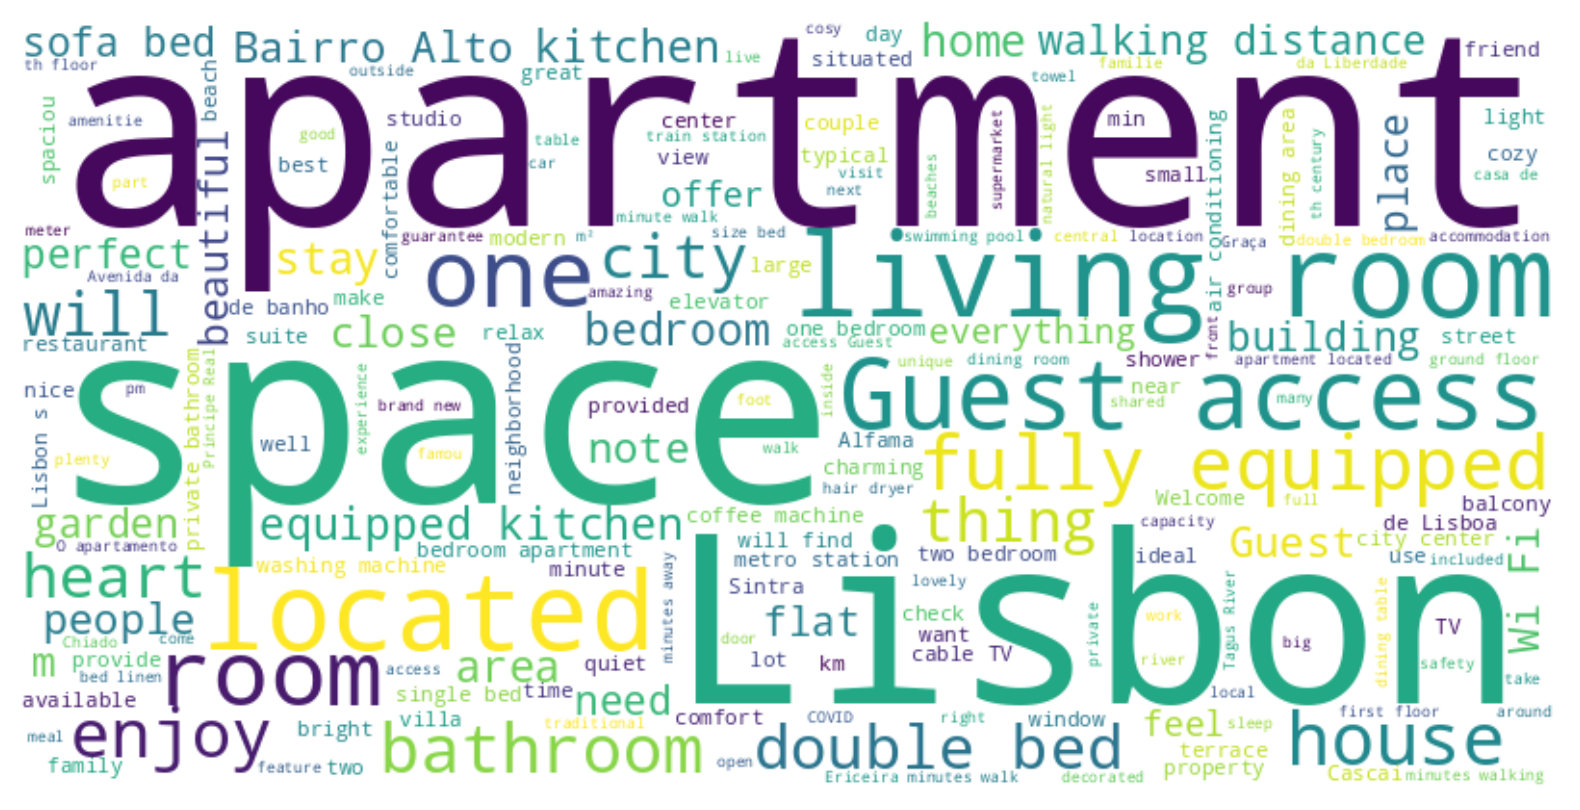

In [ ]:
# Combine all descriptions into a single string
text = ' '.join(train['description'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

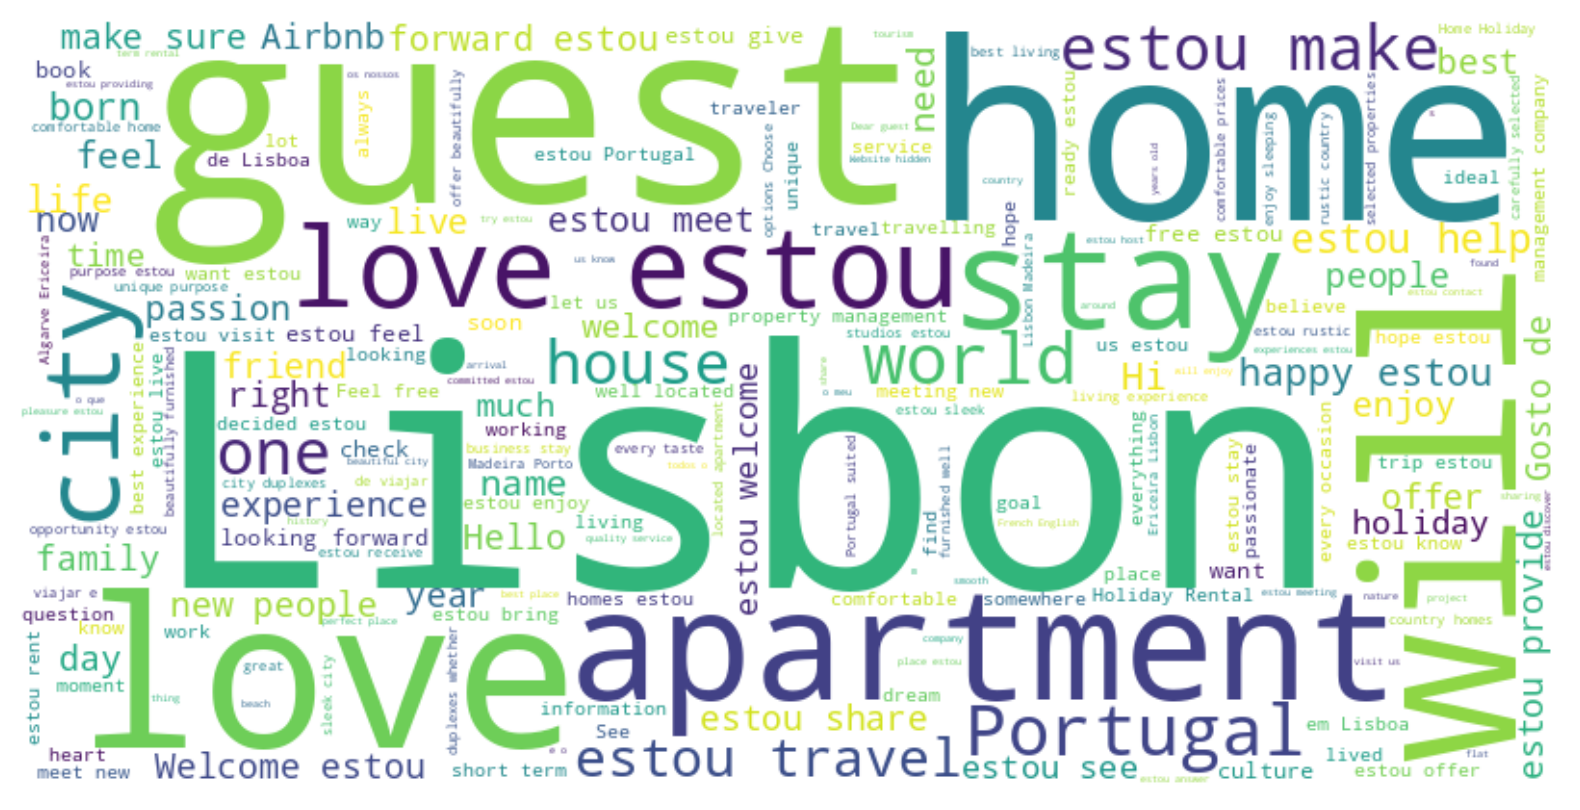

In [ ]:
# Combine all descriptions into a single string
text = ' '.join(train['host_about'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

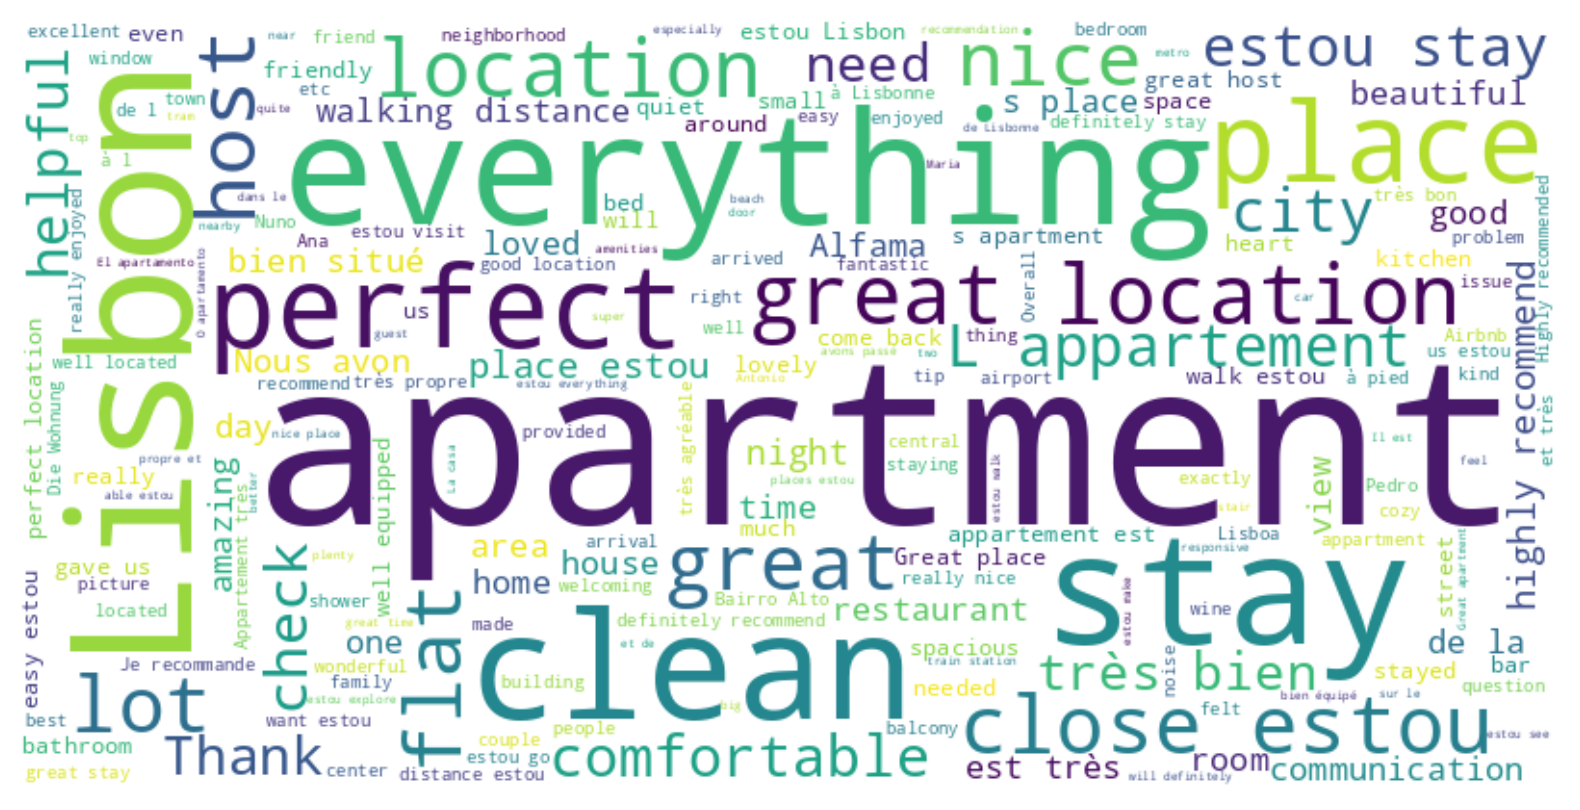

In [ ]:
# Combine all descriptions into a single string
text = ' '.join(test_reviews['comments'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word frequency bar charts

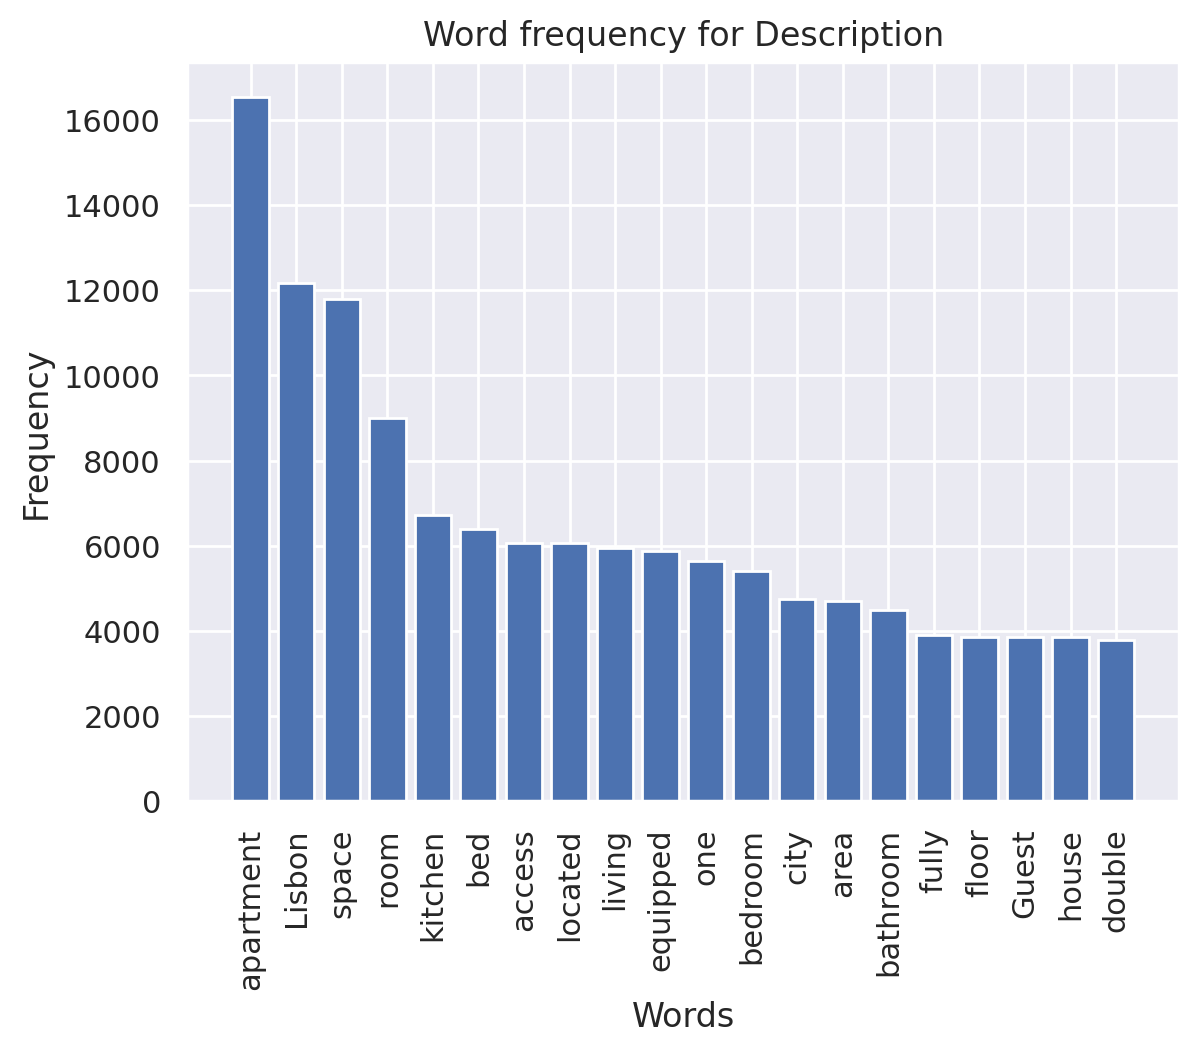

In [ ]:
# Tokenize and count word frequencies while removing stopwords in EN and PT
stop_words_en = set(stopwords.words('english'))
stop_words_pt = set(stopwords.words('portuguese'))
stop_words_fr = set(stopwords.words('french'))
word_counts = Counter()
for description in train['description']:
    tokens = word_tokenize(description)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words_en and token.lower() not in stop_words_pt and token.lower() not in stop_words_fr]
    word_counts.update(filtered_tokens)

# Select top N words
top_n = 20  # Number of top words to include
top_words = dict(word_counts.most_common(top_n))

# Create bar chart
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word frequency for Description')
plt.xticks(rotation=90)
plt.show()

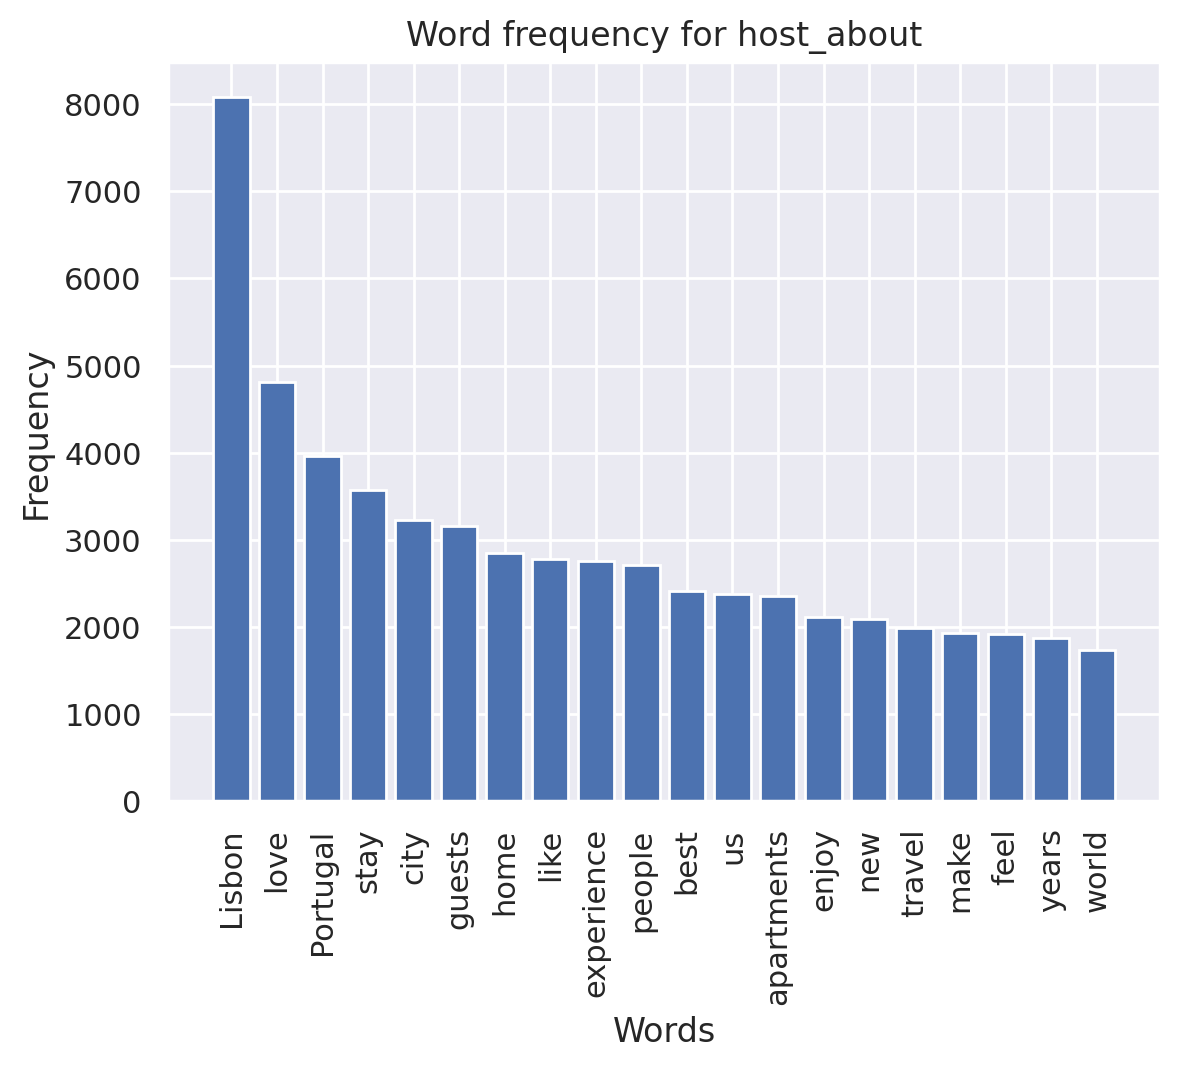

In [ ]:
# Tokenize and count word frequencies while removing stopwords in EN and PT
stop_words_en = set(stopwords.words('english'))
stop_words_pt = set(stopwords.words('portuguese'))
stop_words_fr = set(stopwords.words('french'))
word_counts = Counter()
for host_about in train['host_about']:
    tokens = word_tokenize(host_about)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words_en and token.lower() not in stop_words_pt and token.lower() not in stop_words_fr]
    word_counts.update(filtered_tokens)

# Select top N words
top_n = 20  # Number of top words to include
top_words = dict(word_counts.most_common(top_n))

# Create bar chart
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word frequency for host_about')
plt.xticks(rotation=90)
plt.show()

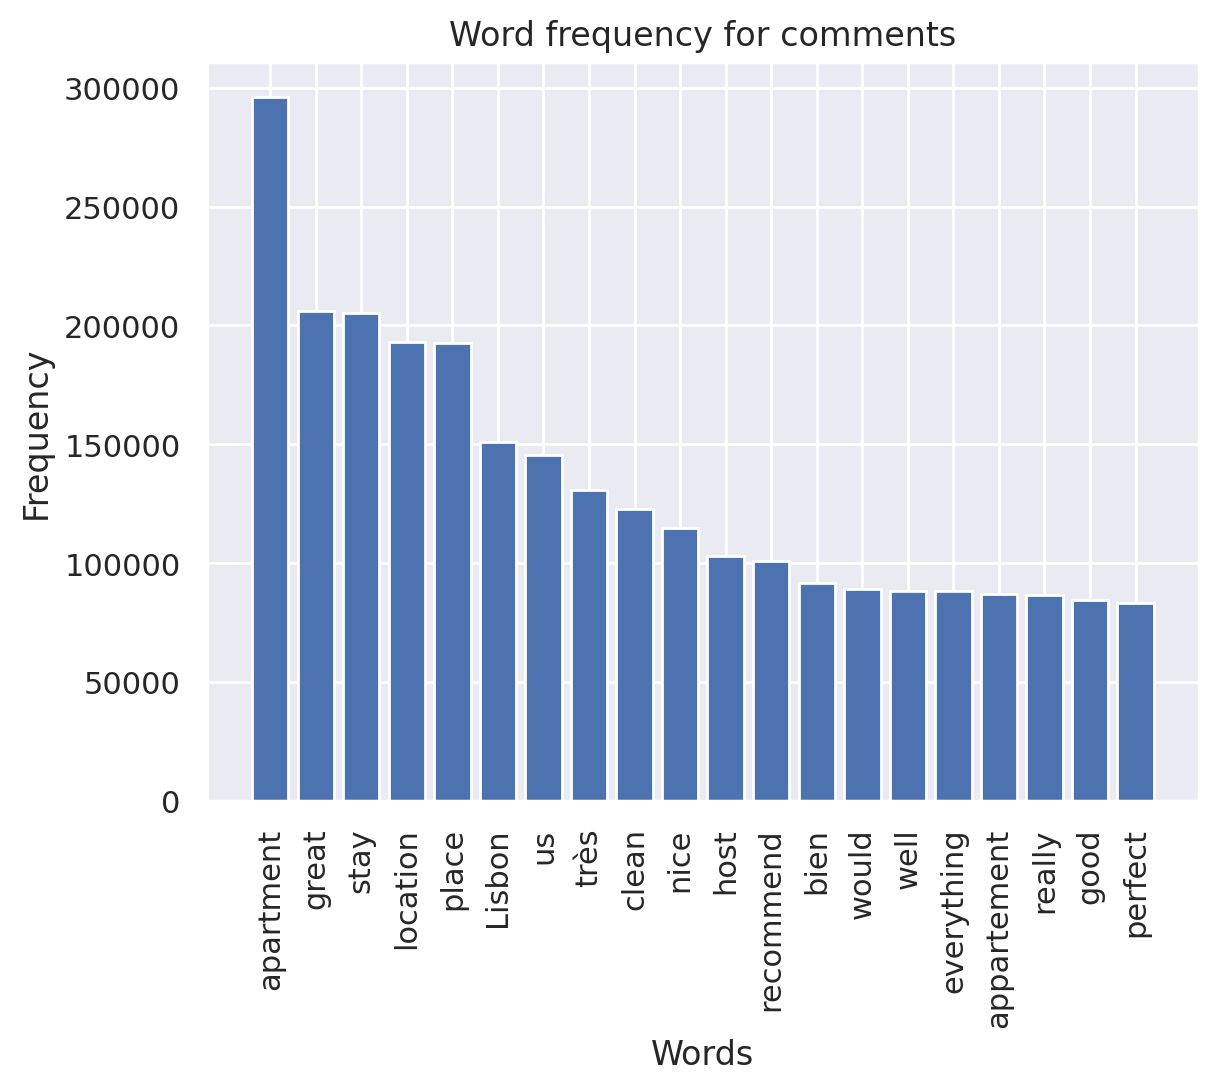

In [ ]:
# Tokenize and count word frequencies while removing stopwords in EN and PT
stop_words_en = set(stopwords.words('english'))
stop_words_pt = set(stopwords.words('portuguese'))
stop_words_fr = set(stopwords.words('french'))
word_counts = Counter()
for comments in train_reviews['comments']:
    tokens = word_tokenize(comments)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words_en and token.lower() not in stop_words_pt and token.lower() not in stop_words_fr]
    word_counts.update(filtered_tokens)

# Select top N words
top_n = 20  # Number of top words to include
top_words = dict(word_counts.most_common(top_n))

# Create bar chart
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word frequency for comments')
plt.xticks(rotation=90)
plt.show()

## Meta data for the text

In [ ]:
train['description_length_symbols'] = train['description'].apply(lambda x: len(x))
train['description_length_words'] = train['description'].apply(lambda x: len(x.split()))
train['host_about_length_symbols'] = train['host_about'].apply(lambda x: len(x))
train['host_about_length_words'] = train['host_about'].apply(lambda x: len(x.split()))
train_reviews['comments_length_symbols'] = train_reviews['comments'].apply(lambda x: len(x))
train_reviews['comments_length_words'] = train_reviews['comments'].apply(lambda x: len(x.split()))

test['description_length_symbols'] = test['description'].apply(lambda x: len(x))
test['description_length_words'] = test['description'].apply(lambda x: len(x.split()))
test['host_about_length_symbols'] = test['host_about'].apply(lambda x: len(x))
test['host_about_length_words'] = test['host_about'].apply(lambda x: len(x.split()))
test_reviews['comments_length_symbols'] = test_reviews['comments'].apply(lambda x: len(x))
test_reviews['comments_length_words'] = test_reviews['comments'].apply(lambda x: len(x.split()))

In [ ]:
stat_sample_with_unlisted(train,['description_length_words'])

cnt  percentage  sum unlisted  unlisted rate
description_length_words                                              
0                         192        1.54            80          0.417
1                          14        0.11             7          0.500
2                           5        0.04             1          0.200
3                          12        0.10             5          0.417
4                          11        0.09             2          0.182
...                       ...         ...           ...            ...
188                         3        0.02             0          0.000
189                         4        0.03             0          0.000
190                         4        0.03             0          0.000
192                         1        0.01             1          1.000
201                         1        0.01             0          0.000

[193 rows x 4 columns]

<Axes: xlabel='description_length_words'>

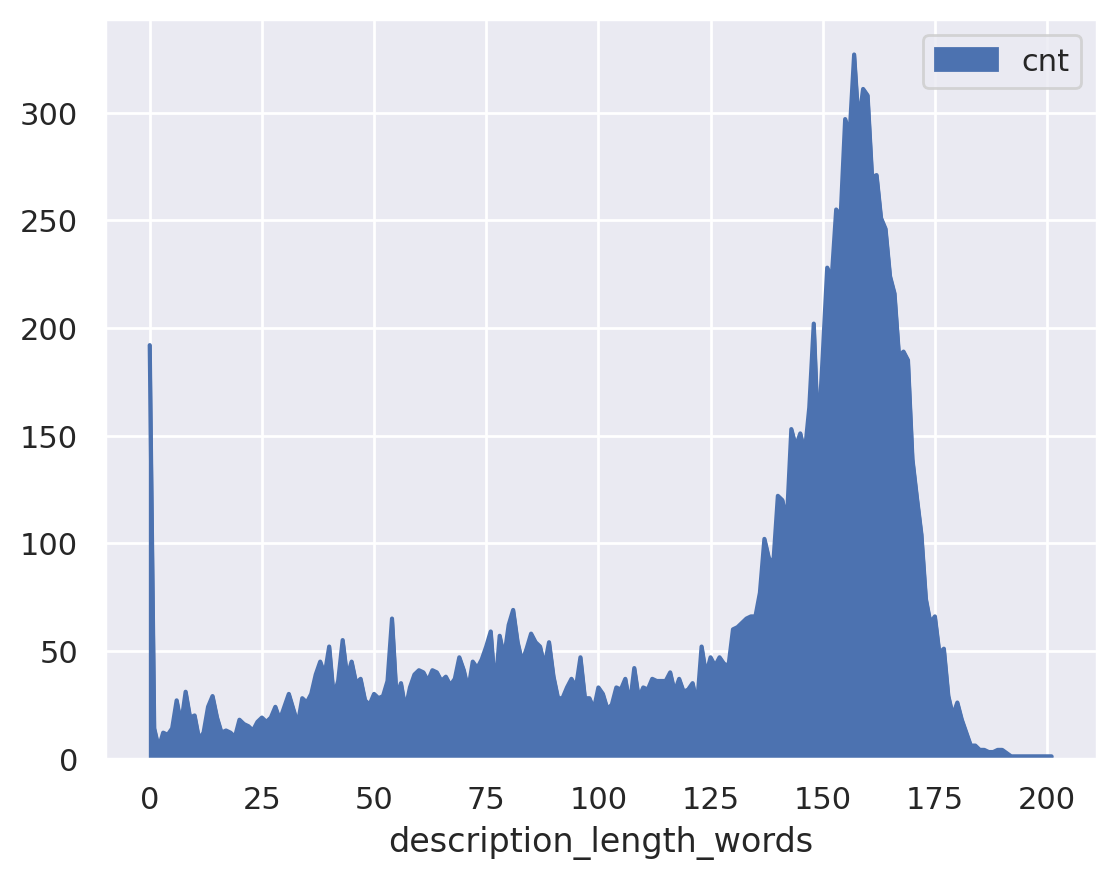

In [ ]:
stat_sample_with_unlisted(train,['description_length_words']).plot(y='cnt', use_index=True, kind = 'area')

In [ ]:
stat_sample_with_unlisted(train,['host_about_length_words'])

cnt  percentage  sum unlisted  unlisted rate
host_about_length_words                                              
0                        169        1.35            40          0.237
1                        186        1.49            66          0.355
2                        298        2.38            74          0.248
3                        189        1.51            62          0.328
4                        197        1.58            64          0.325
...                      ...         ...           ...            ...
535                        1        0.01             0          0.000
580                        1        0.01             0          0.000
594                        2        0.02             1          0.500
611                       15        0.12            15          1.000
1141                       2        0.02             0          0.000

[211 rows x 4 columns]

<Axes: xlabel='host_about_length_words'>

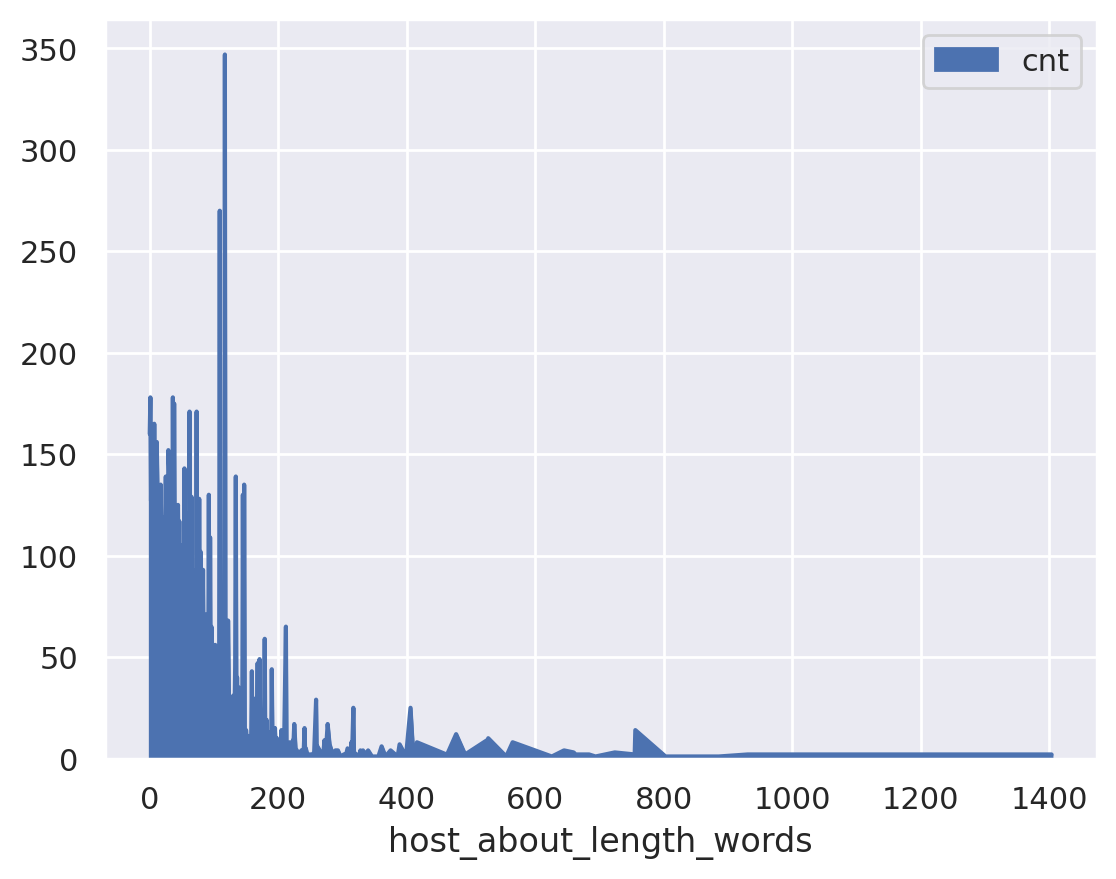

In [ ]:
stat_sample_with_unlisted(train,['host_about_length_words']).plot(y='cnt', use_index=True, kind = 'area')

In [ ]:
stat_sample(test_reviews,['comments_length_words'])

cnt  percentage
comments_length_words                  
0                       247        0.31
1                       842        1.04
2                      1451        1.79
3                       977        1.21
4                      1870        2.31
...                     ...         ...
485                       1        0.00
505                       1        0.00
508                       1        0.00
551                       1        0.00
903                       1        0.00

[320 rows x 2 columns]

<Axes: xlabel='comments_length_words'>

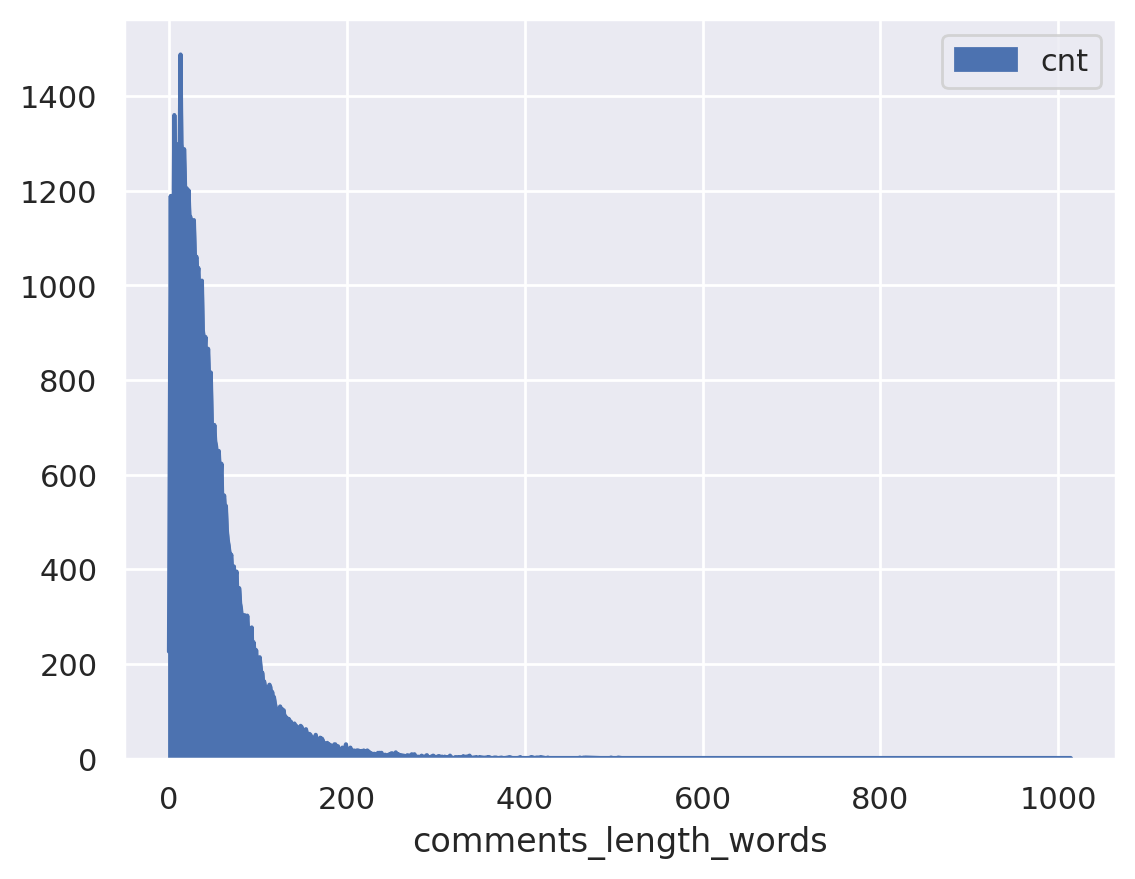

In [ ]:
stat_sample(test_reviews,['comments_length_words']).plot(y='cnt', use_index=True, kind = 'area')

## Standard data preprocessing techniques for the text mining

### Stopwords removal

In [ ]:
# Just checking the stopwords

english_stopwords = stopwords.words('english')
portuguese_stopwords = stopwords.words('portuguese')
french_stopwords = stopwords.words('french')
german_stopwords = stopwords.words('german')
spanish_stopwords = stopwords.words('spanish')
dutch_stopwords = stopwords.words('dutch')
italian_stopwords = stopwords.words('italian')
catalan_stopwords = stopwords.words('catalan')
chinese_stopwords = stopwords.words('chinese')
russian_stopwords = stopwords.words('russian')

print(english_stopwords)
print(portuguese_stopwords)
print(french_stopwords)
print(german_stopwords)
print(spanish_stopwords)
print(dutch_stopwords)
print(italian_stopwords)
print(catalan_stopwords)
print(chinese_stopwords)
print(russian_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# Here only the most common ones from our dataset

stopwords_map = {
    'en': set(stopwords.words('english')),
    'fr': set(stopwords.words('french')),
    'es': set(stopwords.words('spanish')),
    'pt': set(stopwords.words('portuguese')),
    'ca': set(stopwords.words('catalan')),
    'it': set(stopwords.words('italian')),
    'de': set(stopwords.words('german')),
    'fi': set(stopwords.words('finnish')),
    'ru': set(stopwords.words('russian')),
    'zh-cn': set(stopwords.words('chinese')),
    'zh-tw': set(stopwords.words('chinese')),
    'nl': set(stopwords.words('dutch')),
    'ro': set(stopwords.words('romanian')),
    'no': set(stopwords.words('norwegian')),
    'da': set(stopwords.words('danish'))
}

In [ ]:
def remove_stopwords_all(text, lang):
    if lang in stopwords_map:
        stop_words = stopwords_map[lang]
        words = text.split()
        filtered_words = [word for word in words if word.casefold() not in stop_words]
        return ' '.join(filtered_words)
    return text

# Just in case will remove stopwords in Portuguese and English (two most common languages) from all rows
# because language detection can be wrong if two or more languages are used in the text

def remove_stopwords_en(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.casefold() not in stop_words]
    return ' '.join(filtered_words)

def remove_stopwords_pt(text):
    stop_words = set(stopwords.words('portuguese'))
    words = text.split()
    filtered_words = [word for word in words if word.casefold() not in stop_words]
    return ' '.join(filtered_words)

In [ ]:
train['description'] = train.apply(lambda row: remove_stopwords_all(row['description'], row['description_language']), axis=1)
train['description'] = train.apply(lambda row: remove_stopwords_en(row['description']), axis=1)
#train['description'] = train.apply(lambda row: remove_stopwords_pt(row['description']), axis=1)
train['host_about'] = train.apply(lambda row: remove_stopwords_all(row['host_about'], row['host_about_language']), axis=1)
train['host_about'] = train.apply(lambda row: remove_stopwords_en(row['host_about']), axis=1)
#train['host_about'] = train.apply(lambda row: remove_stopwords_pt(row['host_about']), axis=1)
train_reviews['comments'] = train_reviews.apply(lambda row: remove_stopwords_en(row['comments']), axis=1)
#train_reviews['comments'] = train_reviews.apply(lambda row: remove_stopwords_pt(row['comments']), axis=1)

test['description'] = test.apply(lambda row: remove_stopwords_all(row['description'], row['description_language']), axis=1)
test['description'] = test.apply(lambda row: remove_stopwords_en(row['description']), axis=1)
#test['description'] = test.apply(lambda row: remove_stopwords_pt(row['description']), axis=1)
test['host_about'] = test.apply(lambda row: remove_stopwords_all(row['host_about'], row['host_about_language']), axis=1)
test['host_about'] = test.apply(lambda row: remove_stopwords_en(row['host_about']), axis=1)
#test['host_about'] = test.apply(lambda row: remove_stopwords_pt(row['host_about']), axis=1)
test_reviews['comments'] = test_reviews.apply(lambda row: remove_stopwords_en(row['comments']), axis=1)
#test_reviews['comments'] = test_reviews.apply(lambda row: remove_stopwords_pt(row['comments']), axis=1)

### Stemming

In [ ]:
# Create the stemmer objects for each supported language
stemmers = {
    'da': SnowballStemmer('danish'),
    'nl': SnowballStemmer('dutch'),
    'en': SnowballStemmer('english'),
    'fi': SnowballStemmer('finnish'),
    'fr': SnowballStemmer('french'),
    'de': SnowballStemmer('german'),
    'hu': SnowballStemmer('hungarian'),
    'it': SnowballStemmer('italian'),
    'no': SnowballStemmer('norwegian'),
    'pt': SnowballStemmer('portuguese'),
    'ro': SnowballStemmer('romanian'),
    'ru': SnowballStemmer('russian'),
    'es': SnowballStemmer('spanish'),
    'sv': SnowballStemmer('swedish')
}

# Function to perform stemming based on language
def stem_description(description, language):
    if language in stemmers:
        stemmer = stemmers[language]
        return ' '.join([stemmer.stem(word) for word in description.split()])
    else:
        return description

In [ ]:
# Apply stemming to the listings
train['description'] = train.apply(lambda row: stem_description(row['description'], row['description_language']), axis=1)
train['host_about'] = train.apply(lambda row: stem_description(row['host_about'], row['host_about_language']), axis=1)
#train['description'] = train.apply(lambda row: stem_description(row['description'], 'pt'), axis=1)
#train['host_about'] = train.apply(lambda row: stem_description(row['host_about'], 'pt'), axis=1)
train['description'] = train.apply(lambda row: stem_description(row['description'], 'en'), axis=1)
train['host_about'] = train.apply(lambda row: stem_description(row['host_about'], 'en'), axis=1)

test['description'] = test.apply(lambda row: stem_description(row['description'], row['description_language']), axis=1)
test['host_about'] = test.apply(lambda row: stem_description(row['host_about'], row['host_about_language']), axis=1)
#test['description'] = test.apply(lambda row: stem_description(row['description'], 'pt'), axis=1)
#test['host_about'] = test.apply(lambda row: stem_description(row['host_about'], 'pt'), axis=1)
test['description'] = test.apply(lambda row: stem_description(row['description'], 'en'), axis=1)
test['host_about'] = test.apply(lambda row: stem_description(row['host_about'], 'en'), axis=1)

In [ ]:
# Apply stemming to the comments
#train_reviews['comments'] = train.apply(lambda row: stem_description(row['description'], 'pt'), axis=1)
train_reviews['comments'] = train_reviews.apply(lambda row: stem_description(row['comments'], 'en'), axis=1)

#test_reviews['comments'] = test.apply(lambda row: stem_description(row['description'], 'pt'), axis=1)
test_reviews['comments'] = test_reviews.apply(lambda row: stem_description(row['comments'], 'en'), axis=1)

### Lemmatization

In [ ]:
# Initialize lemmatizers
lemmatizer_en = WordNetLemmatizer()
lemmatizer_pt = nltk.stem.RSLPStemmer()
lemmatizer_fr = nltk.stem.SnowballStemmer('french')
lemmatizer_es = nltk.stem.SnowballStemmer('spanish')
lemmatizer_it = nltk.stem.SnowballStemmer('italian')
lemmatizer_ru = nltk.stem.SnowballStemmer('russian')
lemmatizer_de = nltk.stem.SnowballStemmer('german')
lemmatizer_nl = nltk.stem.snowball.DutchStemmer()
lemmatizer_ro = nltk.stem.snowball.RomanianStemmer()
lemmatizer_sv = nltk.stem.snowball.SwedishStemmer()
lemmatizer_no = nltk.stem.snowball.NorwegianStemmer()

# Function to perform lemmatization based on language
def lemmatize_text(text, language):
    if language == 'en':
        return ' '.join([lemmatizer_en.lemmatize(word) for word in text.split()])
    elif language == 'pt':
        return ' '.join([lemmatizer_pt.stem(word) for word in text.split()])
    elif language == 'fr':
        return ' '.join([lemmatizer_fr.stem(word) for word in text.split()])
    elif language == 'es':
        return ' '.join([lemmatizer_es.stem(word) for word in text.split()])
    elif language == 'it':
        return ' '.join([lemmatizer_it.stem(word) for word in text.split()])
    elif language == 'ru':
        return ' '.join([lemmatizer_ru.stem(word) for word in text.split()])
    elif language == 'de':
        return ' '.join([lemmatizer_de.stem(word) for word in text.split()])
    elif language == 'nl':
        return ' '.join([lemmatizer_nl.stem(word) for word in text.split()])
    elif language == 'ro':
        return ' '.join([lemmatizer_ro.stem(word) for word in text.split()])
    elif language == 'sv':
        return ' '.join([lemmatizer_sv.stem(word) for word in text.split()])
    elif language == 'no':
        return ' '.join([lemmatizer_no.stem(word) for word in text.split()])
    else:
        return text

In [ ]:
# Apply lemmatization to the description column
all_to_string()
train['description'] = train.apply(lambda row: lemmatize_text(row['description'], row['description_language']), axis=1)
train['host_about'] = train.apply(lambda row: lemmatize_text(row['host_about'], row['host_about_language']), axis=1)
train['description'] = train.apply(lambda row: lemmatize_text(row['description'], 'en'), axis=1)
train['host_about'] = train.apply(lambda row: lemmatize_text(row['host_about'], 'en'), axis=1)
train_reviews['comments'] = train_reviews.apply(lambda row: lemmatize_text(row['comments'], 'en'), axis=1)

test['description'] = test.apply(lambda row: lemmatize_text(row['description'], row['description_language']), axis=1)
test['host_about'] = test.apply(lambda row: lemmatize_text(row['host_about'], row['host_about_language']), axis=1)
test['description'] = test.apply(lambda row: lemmatize_text(row['description'], 'en'), axis=1)
test['host_about'] = test.apply(lambda row: lemmatize_text(row['host_about'], 'en'), axis=1)
test_reviews['comments'] = test_reviews.apply(lambda row: lemmatize_text(row['comments'], 'en'), axis=1)

## Working with comments

In [ ]:
# Group by 'index' and calculate metrics

train_reviews['comments'] = train_reviews['comments'].astype(str)
train_reviews_modified = train_reviews.groupby('index', as_index=False).agg(num_reviews=('comments', 'count'),
                                                     concatenated_reviews=('comments', ' '.join),
                                                     avg_review_length_words=('comments', lambda x: x.str.split().apply(len).mean()),
                                                     avg_review_length_symbols=('comments', lambda x: x.str.len().mean()))

# Rename columns
#df_modified.columns = ['num_reviews', 'concatenated_reviews', 'avg_review_length_words', 'avg_review_length_symbols']

In [ ]:
train_reviews_modified.sort_values('num_reviews')

index  num_reviews                               concatenated_reviews  \
5411   7947            1  VW California is a great small camper - robust...   
4595   6760            1  Sergio is very kind.<br/>We were a bit late an...   
1699   2503            1  It’s a nice room in a shared flat with young p...   
509     728            1                  Great place and thoughtful hosts!   
3611   5331            1                    Super clean, cozy and friendly!   
...     ...          ...                                                ...   
2308   3396          765  I stayed @ Isabel's place for one night. Isabe...   
4571   6720          788  The apartment is in a perfect location, public...   
177     265          891  Our host was charming and helpful, making sure...   
6383   9374          896  Everything was perfect: the appartement is ver...   
6074   8911         1175  Antonio is a very  welcoming personn. He came ...   

      avg_review_length_words  avg_review_length_symbols  
5411                53.000000                 301.000000  
4595                19.000000                 115.000000  
1699                37.000000                 181.000000  
509                  5.000000                  33.000000  
3611                 5.000000                  31.000000  
...                       ...                        ...  
2308                36.573856                 211.406536  
4571                70.782995                 418.522843  
177                 49.318743                 290.263749  
6383                44.379464                 262.016741  
6074                41.746383                 242.116596  

[8467 rows x 5 columns]

After seeing the word counts for the comments and checking how big the data is there we decided not to proceed further with extracting the information from the comments. Also as per the project requirements we can decide to use just one textual column for our analysis

## Saving intermediate tables

As it takes a long time to execute preprocessing steps it is a good idea to save the results on a disc. Uncomment this if needed

In [ ]:
#train.to_excel('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/train_preproc.xlsx', index=False)
#test.to_excel('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/test_preproc.xlsx', index=False)
#train_reviews.to_excel('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/train_reviews_preproc.xlsx', index=False)
# test_reviews.to_excel('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/test_reviews_preproc.xlsx', index=False)

# Feature engineering

## Loading previously saved preprocessed data

In [ ]:
# Loading preprocessed data.
# We are loading only the listings data as we decided to only work with them, the comments would require more time and computational resources
train_preproc = pd.read_excel("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/train_preproc.xlsx")
test_preproc = pd.read_excel("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/test_preproc.xlsx")
# train_reviews_preproc = pd.read_excel("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/train_reviews_preproc.xlsx")
# test_reviews_preproc = pd.read_excel("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/test_reviews_preproc.xlsx")

## Split data into train and validation

In [ ]:
train_preproc.dropna(inplace=True)
test_preproc.dropna(inplace=True)
train_df, val_df = train_test_split(train_preproc, test_size=0.2, random_state=42)
train_df['description_host'] = train_df['description'] + " " + train_df['host_about']
val_df['description_host'] = val_df['description'] + " " + val_df['host_about']

## Bag-of-Words (BoW)


In [ ]:
bow = CountVectorizer(binary=True)
X_bow = bow.fit_transform(train_df["description"].values)
X_val_bow = bow.transform(val_df["description"].values)

In [ ]:
bow_host = CountVectorizer(binary=True)
X_bow_host = bow_host.fit_transform(train_df["host_about"].values)
X_val_bow_host = bow_host.transform(val_df["host_about"].values)

In [ ]:
y = np.array(train_df["unlisted"])
y_val = np.array(val_df["unlisted"])

## Term Frequency-Inverse Document Frequency (TF-IDF)

In [ ]:
word_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 1))
X_word = word_tfidf.fit_transform(train_df["description"].astype(str))
X_val = word_tfidf.transform(val_df['description'].astype(str))

In [ ]:
word_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 1))
X_word_host = word_tfidf.fit_transform(train_df["host_about"].astype(str))
X_val_host = word_tfidf.transform(val_df['host_about'].astype(str))

In [ ]:
word_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 1))
X_word_desc_host = word_tfidf.fit_transform(train_df["description_host"].astype(str))
X_val_desc_host = word_tfidf.transform(val_df['description_host'].astype(str))

## Glove

In [ ]:
# URL download
url = "https://nlp.stanford.edu/data/glove.6B.zip"
save_path = "/content/gdrive/MyDrive/Text Mining Project/Project Corpora/glove.6B.zip"
response = requests.get(url)
with open(save_path, 'wb') as f:
    f.write(response.content)

# unzip and define glove
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(save_path))
glove_input_file = "/content/gdrive/MyDrive/Text Mining Project/Project Corpora/glove.6B.100d.txt"

#tokenization of the description
nltk.download('punkt')
train_preproc['tokens'] = train_preproc['description'].apply(lambda x: nltk.word_tokenize(x) if type(x) == str else [])
train_preproc['tokens_host_about'] = train_preproc['host_about'].apply(lambda x: nltk.word_tokenize(x) if type(x) == str else [])
test_preproc['tokens'] = test_preproc['description'].apply(lambda x: nltk.word_tokenize(x) if type(x) == str else [])
test_preproc['tokens_host_about'] = test_preproc['host_about'].apply(lambda x: nltk.word_tokenize(x) if type(x) == str else [])

#Using the GloVe pretrained file
glove_input_file = ("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/glove.6B.100d.txt")
word2vec_output_file = ("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/glove.6B.100d.txt.word2vec")
glove2word2vec(glove_input_file, word2vec_output_file)

# Loading with word2vec format
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Necessary Functions for the embedding
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=100):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

def get_word2vec_embeddings_host_about(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens_host_about'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

embeddings_train = get_word2vec_embeddings(model, train_preproc)
embeddings_host_about_train = get_word2vec_embeddings_host_about(model, train_preproc)
embeddings_test = get_word2vec_embeddings(model, test_preproc)
embeddings_host_about_test = get_word2vec_embeddings_host_about(model, test_preproc)

train_preproc['description_embeddings'] = embeddings_train
train_preproc['host_about_embeddings'] = embeddings_host_about_train
test_preproc['description_embeddings'] = embeddings_test
test_preproc['host_about_embeddings'] = embeddings_host_about_test

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-102-ae41deb02bc3>:24: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [ ]:
print(embeddings_test[0])
print(embeddings_host_about_test[0])

[-0.07608384  0.01361887  0.00262754  0.08392194 -0.03791893  0.14659804
 -0.03434105  0.21051331  0.07490911  0.0978267   0.15483377 -0.0766394
  0.00565573  0.06077806  0.01741482 -0.14108869  0.16187553  0.16896895
 -0.14884144  0.03294008  0.03885171  0.06262583  0.05238347 -0.02299744
  0.04205215 -0.22548128 -0.14639678 -0.24690492  0.03045555 -0.11141088
 -0.27560599 -0.09539306  0.10884276  0.08571873  0.07273751  0.16877569
  0.05484034  0.02746659  0.03006889 -0.00843154  0.02532295 -0.21252833
  0.03248971 -0.11517319  0.0645641   0.05573085  0.05123358  0.02475266
  0.00672053 -0.02285706 -0.09415542  0.05398693 -0.11162706  0.3496668
 -0.19964137 -1.19459591 -0.18074612  0.01072265  0.58760013  0.14221511
 -0.11066171  0.35823316 -0.12988842 -0.03329548  0.22324058  0.07661479
  0.06712345 -0.10409134  0.03844372 -0.02755339  0.09956797  0.06957068
  0.07811184 -0.2907039   0.09065066 -0.15647623 -0.04885298  0.10496684
 -0.21327812  0.09146473  0.07456292 -0.00378812 -0.2

# Classification models

## KNN

### Just a function for plotting confusion matrix

In [ ]:

def plot_cm(confusion_matrix : np.array, classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis.
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes

    Returns:
        - Plot of the Confusion Matrix
    """

    confusionmatrix = confusion_matrix
    class_names = classnames

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

### BoW (based on description) + KNN

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
modelknn.fit(X_bow, y)
y_pred = modelknn.predict(X_val_bow)
f1_score(y_val, y_pred, average="weighted")

0.7566547570815987

<ipython-input-133-e2d990908918>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


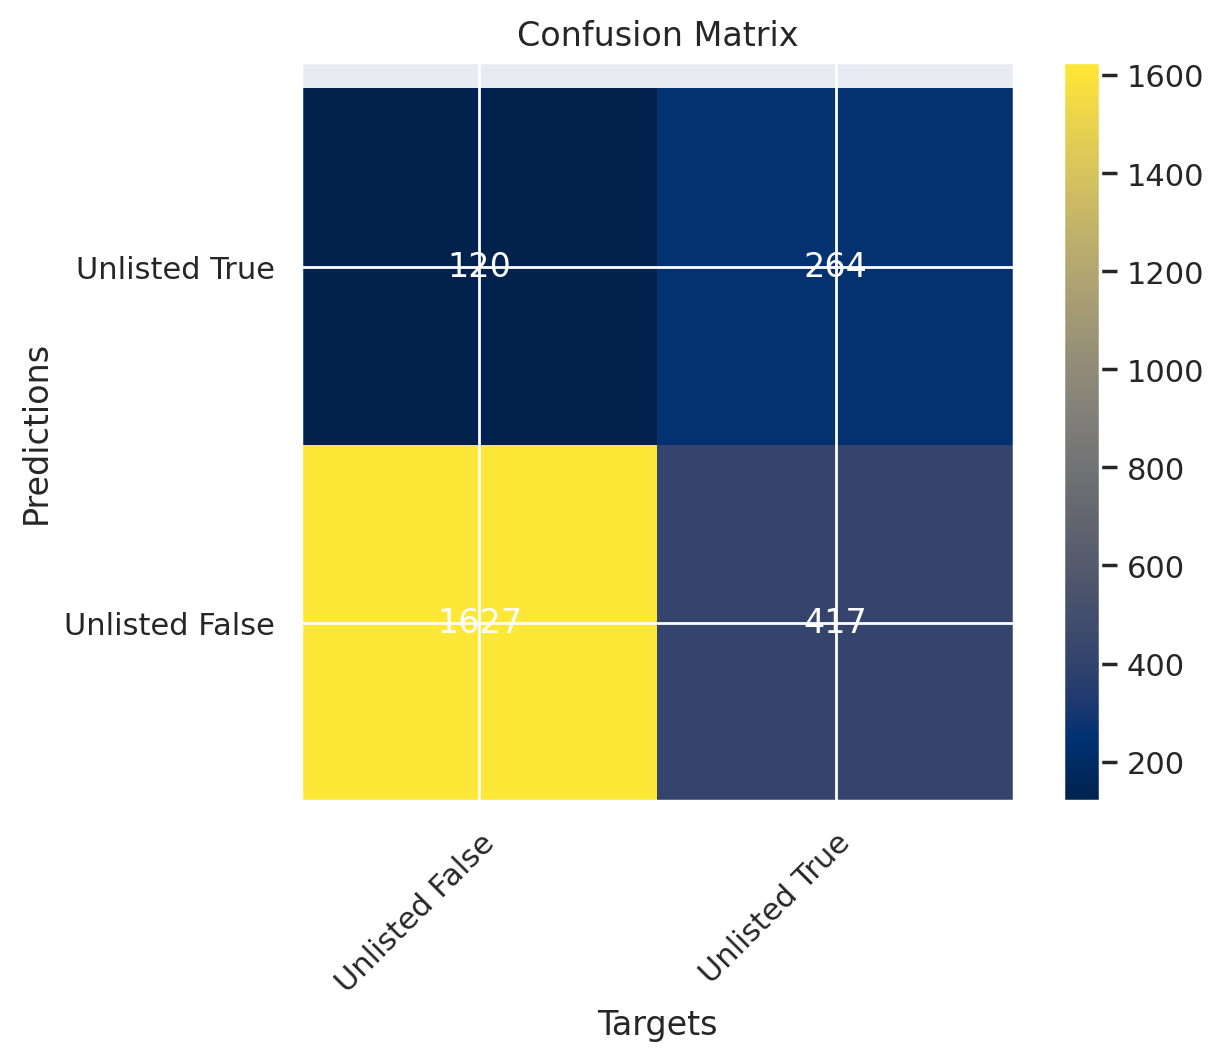

In [ ]:
labels = {"Unlisted False": 0, "Unlisted True": 1}
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

### BoW (based on host_about) + KNN

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
modelknn.fit(X_bow_host, y)
y_pred = modelknn.predict(X_val_bow_host)
f1_score(y_val, y_pred, average="weighted")

0.7643415529565228

### BoW (based on description + host_about) + KNN

In [ ]:
bow_host = CountVectorizer(binary=True)
X_bow_desc_host = bow_host.fit_transform(train_df["description_host"].values)
X_val_bow_desc_host = bow_host.transform(val_df["description_host"].values)

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = 8, metric = 'cosine', weights = 'distance')
modelknn.fit(X_bow_desc_host, y)
y_pred_knn_final = modelknn.predict(X_val_bow_desc_host)
f1_score(y_val, y_pred_knn_final, average="weighted")

0.7793989674296928

<ipython-input-133-e2d990908918>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


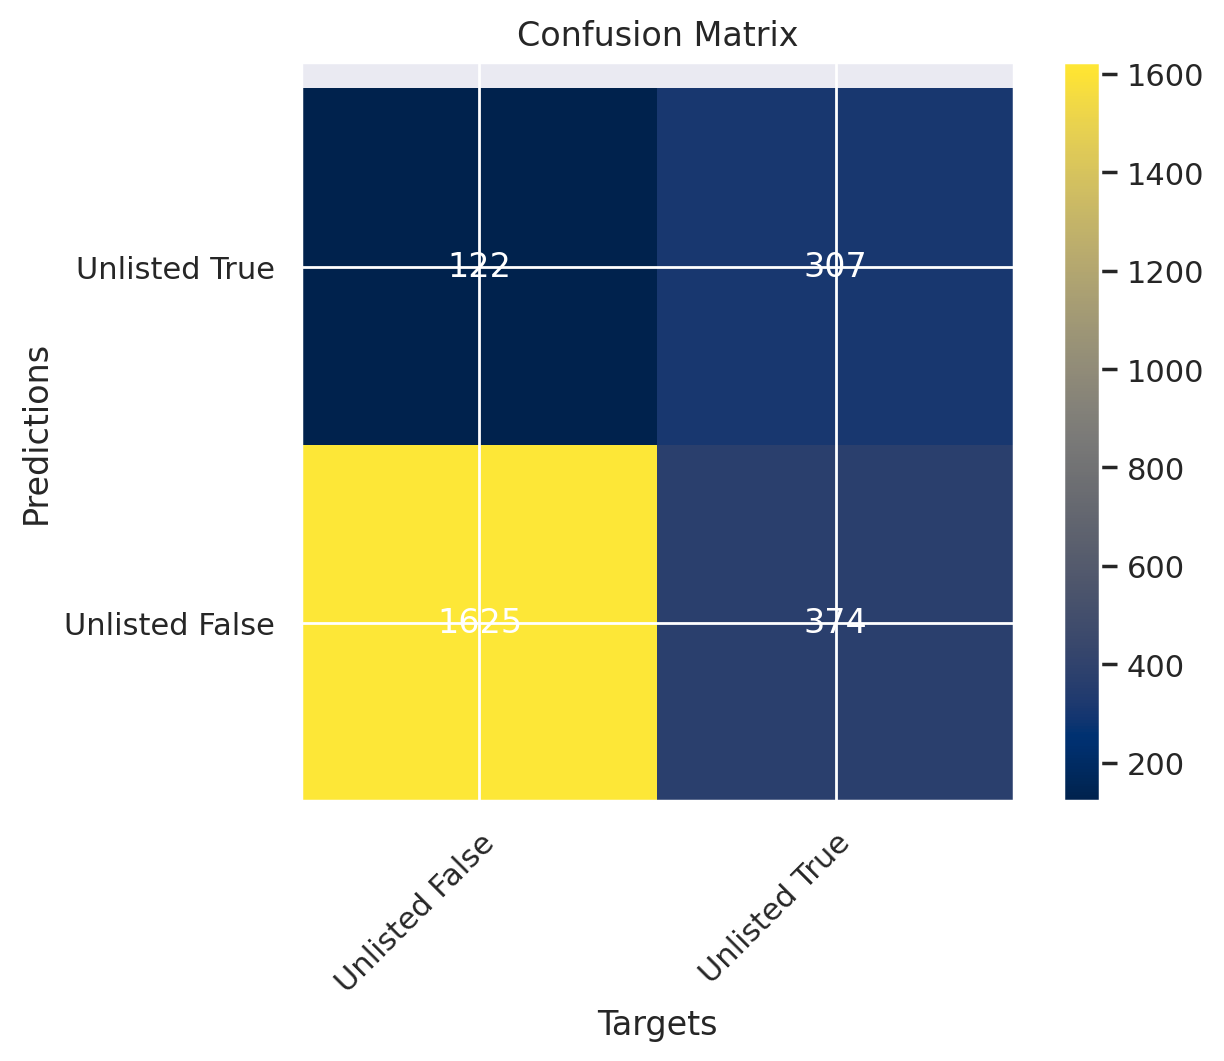

In [ ]:
labels = {"Unlisted False": 0, "Unlisted True": 1}
plot_cm(confusion_matrix(y_pred_knn_final, y_val), labels.keys())

**This one is the best model we have (see next sections)!**

In [ ]:
# Its important to use binary mode
knnPickle = open('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/knn_best_model', 'wb')

# source, destination
pickle.dump(modelknn, knnPickle)

# close the file
knnPickle.close()

### TF-IDF (based on description) + KNN

In [ ]:
#TF-IDF
modelknn = KNeighborsClassifier(n_neighbors = 7, metric = 'cosine', weights = 'distance')
modelknn.fit(X_word, y)
y_pred = modelknn.predict(X_val)
f1_score(y_val, y_pred, average="weighted")

0.7638400342026158

### TF-IDF (based on host_about) + KNN

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
modelknn.fit(X_word_host, y)
y_pred = modelknn.predict(X_val_host)
f1_score(y_val, y_pred, average="weighted")

0.7677995012902415

### TF_IDF (based on description + host_about)

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
modelknn.fit(X_word_desc_host, y)
y_pred = modelknn.predict(X_val_desc_host)
f1_score(y_val, y_pred, average="weighted")

0.775456131613117

## Logistic regression

### BoW (based on description) + Logistic Regression

<ipython-input-133-e2d990908918>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


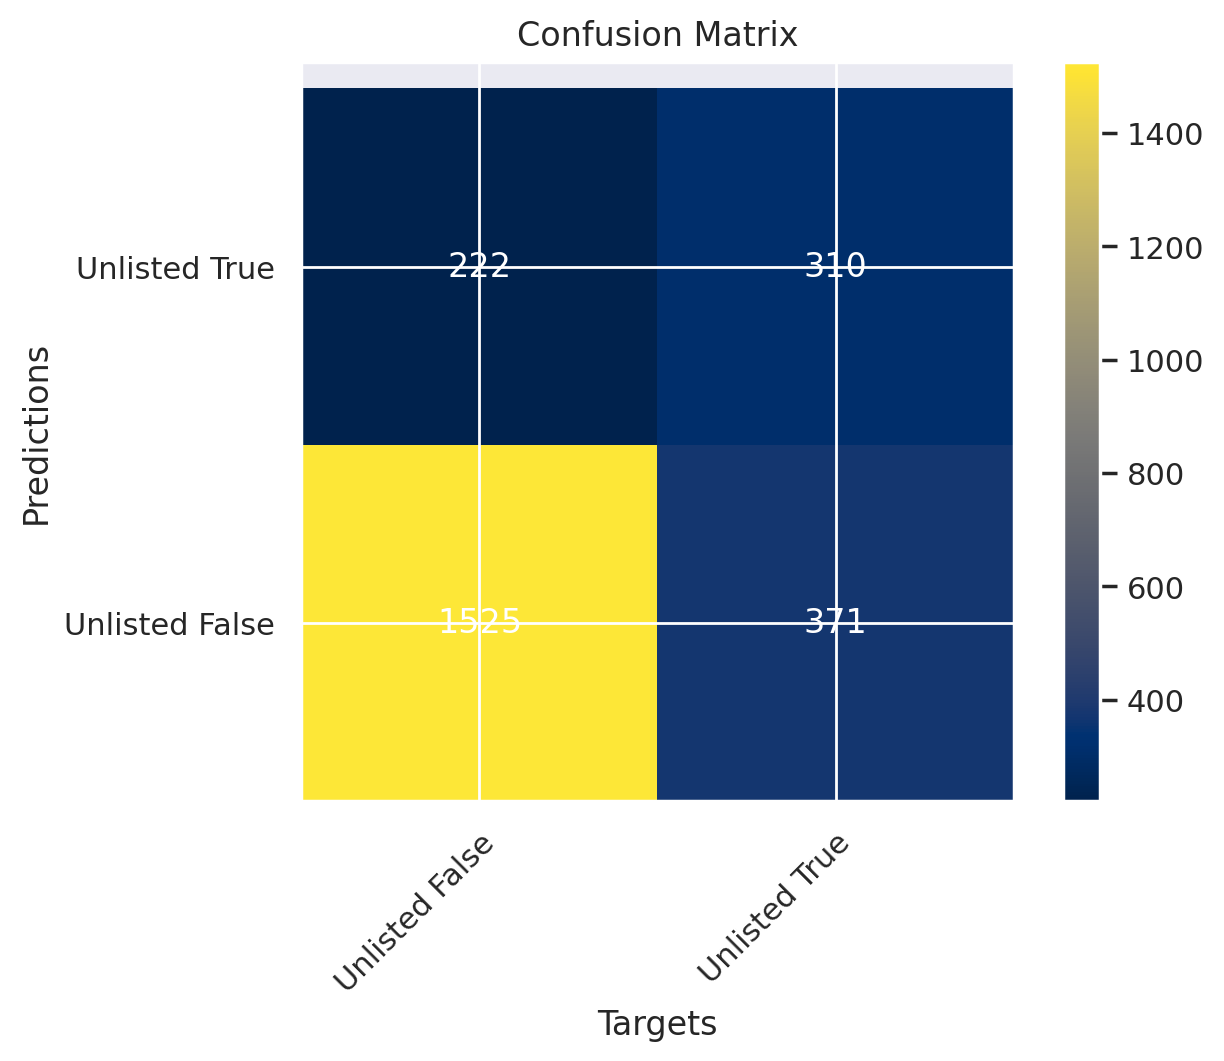

Accuracy:
0.7557660626029654
Precision:
0.5827067669172933
Recall:
0.4552129221732746
F1-score:
0.7457603370787702


In [ ]:
model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
model_lr.fit(X_bow, y)
y_pred = model_lr.predict(X_val_bow)

labels = {"Unlisted False": 0, "Unlisted True": 1}
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

# Scores
print("Accuracy:")
print(accuracy_score(y_val, y_pred))
print("Precision:")
print(precision_score(y_val, y_pred))
print("Recall:")
print(recall_score(y_val, y_pred))
print("F1-score:")
print(f1_score(y_val, y_pred, average="weighted"))

### TF-IDF (based on description) + Logistic Regression

<ipython-input-133-e2d990908918>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


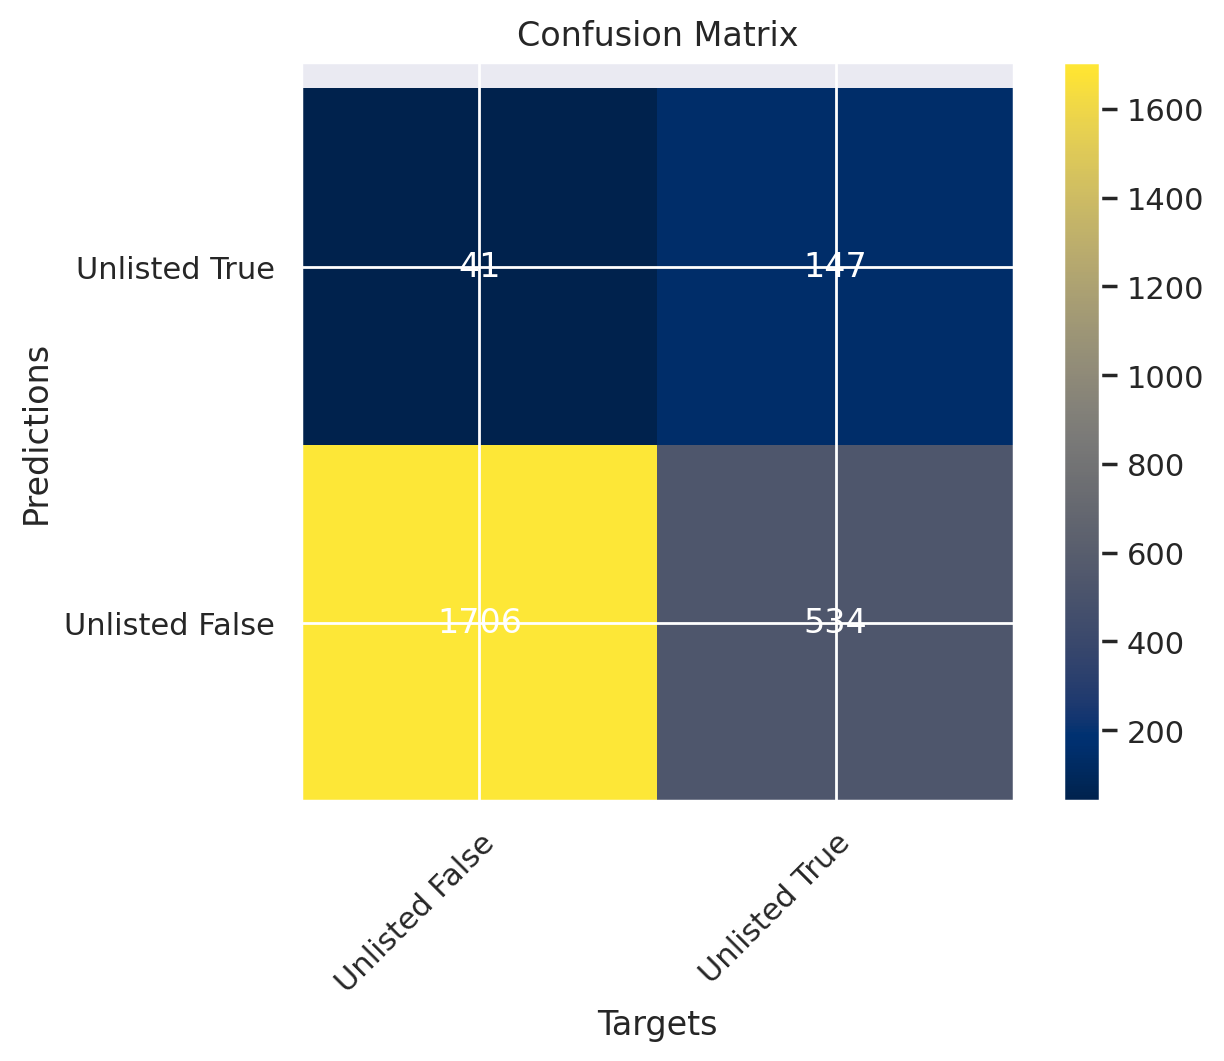

Accuracy:
0.7631795716639209
Precision:
0.7819148936170213
Recall:
0.21585903083700442
F1-score:
0.7106448803632402


In [ ]:
#TF-IDF
model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
model_lr.fit(X_word, y)
y_pred = model_lr.predict(X_val)

labels = {"Unlisted False": 0, "Unlisted True": 1}
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

# Scores
print("Accuracy:")
print(accuracy_score(y_val, y_pred))
print("Precision:")
print(precision_score(y_val, y_pred))
print("Recall:")
print(recall_score(y_val, y_pred))
print("F1-score:")
print(f1_score(y_val, y_pred, average="weighted"))

## Multi Layer Perceptron (MLP)

### BoW (based on description) + MLP

<ipython-input-104-e2d990908918>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


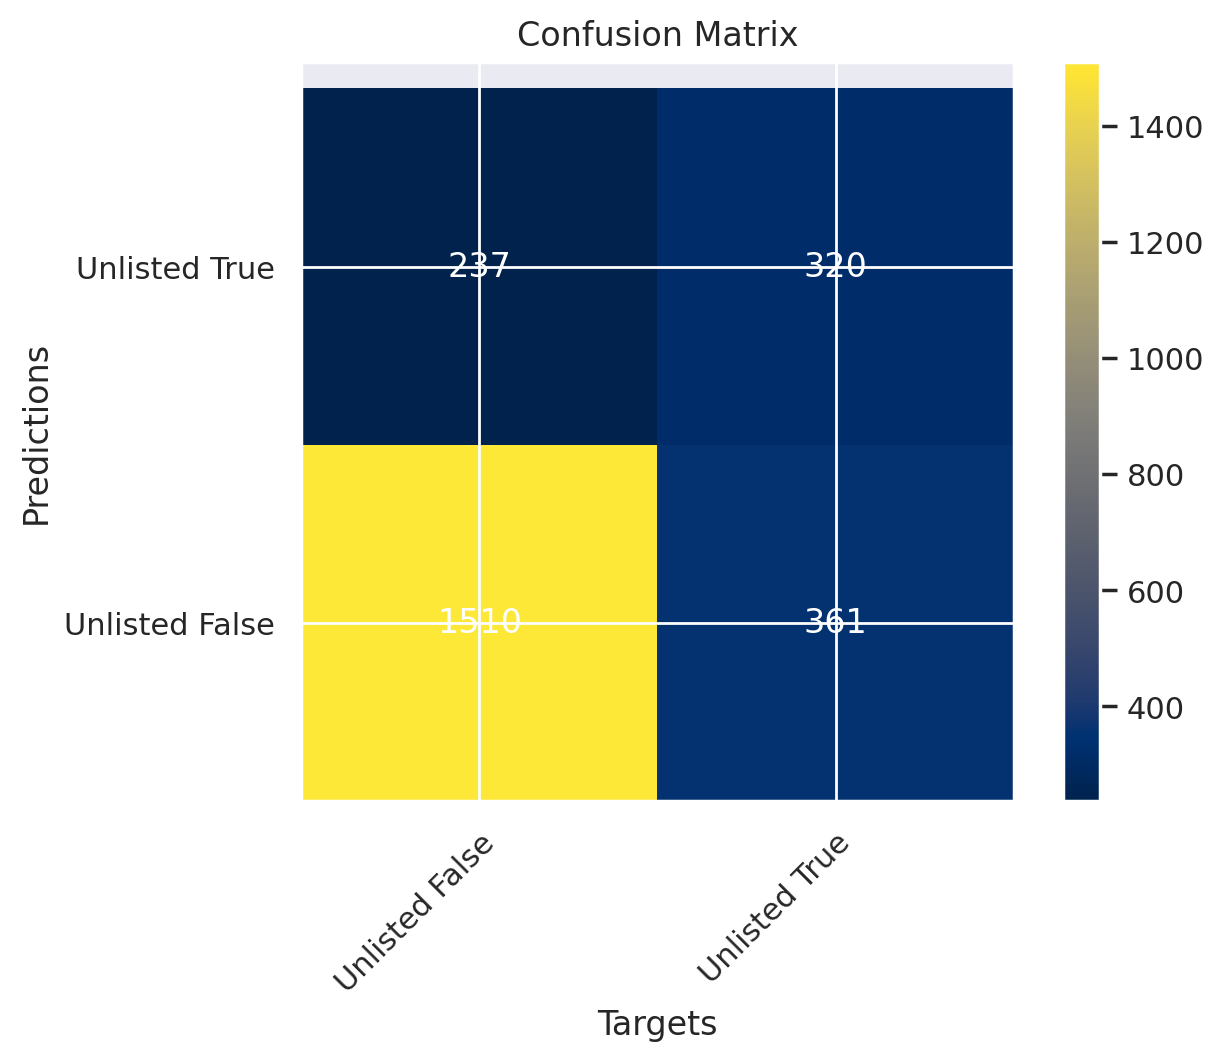

Accuracy:
0.7537067545304778
Precision:
0.5745062836624776
Recall:
0.4698972099853157
F1-score:
0.7455928117463098


In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', random_state=42)
mlp.fit(X_bow, y)
y_pred = mlp.predict(X_val_bow)
labels = {"Unlisted False": 0, "Unlisted True": 1}
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

# Scores
print("Accuracy:")
print(accuracy_score(y_val, y_pred))
print("Precision:")
print(precision_score(y_val, y_pred))
print("Recall:")
print(recall_score(y_val, y_pred))
print("F1-score:")
print(f1_score(y_val, y_pred, average="weighted"))


### TF-IDF (based on description) + MLP

<ipython-input-104-e2d990908918>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


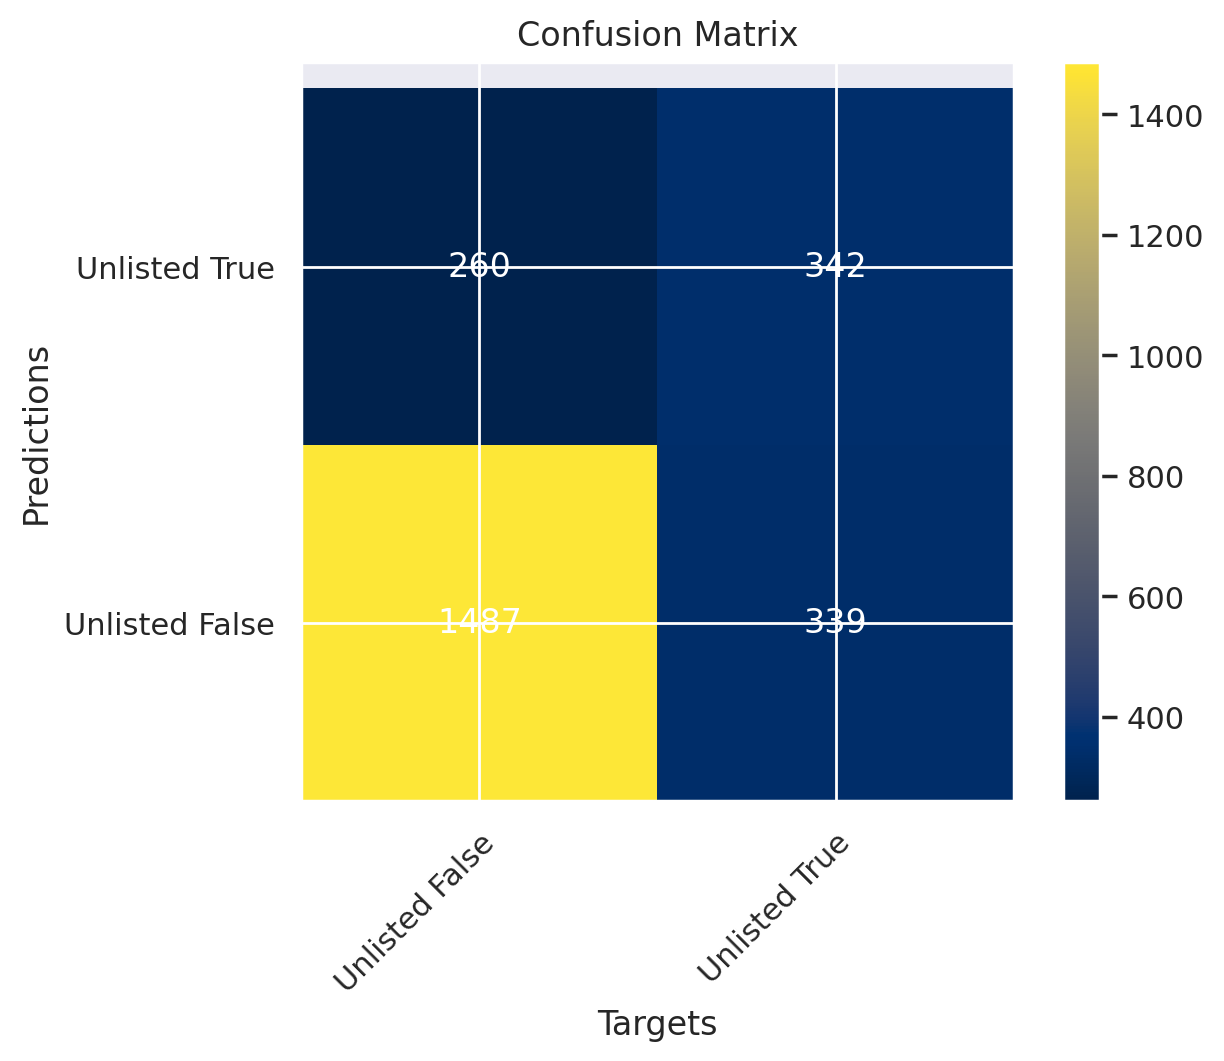

Accuracy:
0.7532948929159803
Precision:
0.5681063122923588
Recall:
0.5022026431718062
F1-score:
0.7484268875825516


In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', random_state=42)
mlp.fit(X_word, y)
y_pred = mlp.predict(X_val)
labels = {"Unlisted False": 0, "Unlisted True": 1}
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

# Scores
print("Accuracy:")
print(accuracy_score(y_val, y_pred))
print("Precision:")
print(precision_score(y_val, y_pred))
print("Recall:")
print(recall_score(y_val, y_pred))
print("F1-score:")
print(f1_score(y_val, y_pred, average="weighted"))


## LSTM

In [ ]:
w2v = gensim.downloader.load('glove-twitter-100')

[=================================================-] 99.3% 384.4/387.1MB downloaded

In [ ]:
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in w2v.index_to_key:
                doc_vectors.append(w2v.word_vec(word))
        corpus_vec.append(doc_vectors)
    return corpus_vec

In [ ]:
x_train_vec = corpus2vec(train_df["description_host"])
x_val_vec = corpus2vec(val_df["description_host"])

  0%|          | 0/9708 [00:00<?, ?it/s]<ipython-input-4-af7aa7cacb26>:10: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  doc_vectors.append(w2v.word_vec(word))
100%|██████████| 2428/2428 [19:55<00:00,  2.03it/s]


In [ ]:
np.save('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/lstm_x_train_vec', x_train_vec)
np.save('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/lstm_x_val_vec', x_val_vec)

In [ ]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [ ]:
X_pad = pad_sequences(maxlen=48,sequences=x_train_vec, padding="post", dtype='float64')

In [ ]:
X = tf.convert_to_tensor(X_pad, dtype='float32')

In [ ]:
y_train_lstm = tf.one_hot(y, depth=2)

In [ ]:
tf.random.set_seed(221)

In [ ]:
'''model input in the shape(number of words per doc, word embedding size)'''
input_ = Input(shape=(48,100))

'''mask layer to avoid model from considering padding vectors'''
mask_layer = Masking(mask_value=0)
mask = mask_layer(input_)

'''BiLSTM layer'''

lstm = Bidirectional(LSTM(units=4))(mask)

'''activation layer'''
act = Dense(2, activation='sigmoid')(lstm)

'''model input and output'''
model = Model(input_, act)

'''model loss function and evaluation metrics'''
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 100)]         0         
                                                                 
 masking (Masking)           (None, 48, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 8)                3360      
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 18        
                                                                 
Total params: 3,378
Trainable params: 3,378
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X, y_train_lstm, batch_size=16, epochs=20, verbose=1, validation_split=0.20)

Epoch 1/20
486/486 [==============================] - 442s 904ms/step - loss: 0.5979 - binary_accuracy: 0.7073 - val_loss: 0.5690 - val_binary_accuracy: 0.7346
Epoch 2/20
486/486 [==============================] - 409s 841ms/step - loss: 0.5731 - binary_accuracy: 0.7253 - val_loss: 0.5589 - val_binary_accuracy: 0.7402
Epoch 3/20
486/486 [==============================] - 413s 850ms/step - loss: 0.5555 - binary_accuracy: 0.7322 - val_loss: 0.5477 - val_binary_accuracy: 0.7477
Epoch 4/20
486/486 [==============================] - 411s 845ms/step - loss: 0.5351 - binary_accuracy: 0.7463 - val_loss: 0.5417 - val_binary_accuracy: 0.7557
Epoch 5/20
486/486 [==============================] - 432s 889ms/step - loss: 0.5176 - binary_accuracy: 0.7570 - val_loss: 0.5340 - val_binary_accuracy: 0.7608
Epoch 6/20
486/486 [==============================] - 406s 834ms/step - loss: 0.5019 - binary_accuracy: 0.7671 - val_loss: 0.5324 - val_binary_accuracy: 0.7611
Epoch 7/20
486/486 [====================

In [ ]:
# model.save('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/lstm_model')

In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/lstm_model')

## GPT2

In [ ]:
from sklearn.metrics import f1_score
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AdamW

#These steps are done in order to allow the GPT2 tokenizer to be used

train_preproc_gpt, test_preproc_gpt = train_test_split(train_preproc, test_size=0.2, random_state=42)

train_texts = train_preproc_gpt['description'].astype(str).tolist()
train_labels = train_preproc_gpt['unlisted'].tolist()
test_texts = test_preproc_gpt['description'].astype(str).tolist()

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

if not tokenizer.pad_token:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=len(set(train_labels)))

model.resize_token_embeddings(len(tokenizer))

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt")


#class for the text classification datasets
class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels) if self.labels else len(self.encodings["input_ids"])

train_dataset = TextClassificationDataset(train_encodings, train_labels)
test_dataset = TextClassificationDataset(test_encodings, None)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

model.to(device)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
optim = AdamW(model.parameters(), lr=5e-5)

epochs = 2
accumulation_steps = 2

#Training
for epoch in range(epochs):
    for index, batch  in enumerate(train_loader):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        if index == 20:
            break
index=0
# Predictions
model.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
test_predictions = []
for index, batch in enumerate(test_loader):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        test_predictions.extend(outputs.logits.argmax(-1).cpu().numpy().tolist())
    if index == 200:
        break

# Print predictions
print("Predictions: ", test_predictions)

Using pad_token, but it is not set yet.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-153-3037d73792ee>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Predictions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
#Confusion matrix and f1-score
y_val = np.array(test_preproc_gpt["unlisted"])
confusion_matrix(test_predictions, y_val[0:201])

f1_score(y_val[0:201], test_predictions, average="weighted")

0.6244992801037791

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate accuracy
accuracy = accuracy_score(y_val[0:201], test_predictions)
print("Accuracy: ", accuracy)

# Calculate precision
precision = precision_score(y_val[0:201], test_predictions, average='weighted')
print("Precision: ", precision)

# Calculate recall
recall = recall_score(y_val[0:201], test_predictions, average='weighted')
print("Recall: ", recall)

Accuracy:  0.736318407960199
Precision:  0.5421647979010421
Recall:  0.736318407960199


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## BERT

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the data into train and test sets
train_df1, val_df1 = train_test_split(train_preproc, test_size=0.2, random_state=42)

train_df1 = train_df1.dropna(subset=['description'])
val_df1 = val_df1.dropna(subset=['description'])

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input texts
train_texts = train_df1['description'].tolist()
train_labels = train_df1['unlisted'].tolist()
test_texts = val_df1['description'].tolist()
test_labels = val_df1['unlisted'].tolist()

# Reduce batch size
batch_size = 8

# Limit the sequence length
max_length = 64

# Tokenize and truncate/pad the input texts
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=max_length)

# Convert the labels to tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Convert the train and test encodings to dictionaries
train_encodings = {'input_ids': train_encodings.input_ids, 'attention_mask': train_encodings.attention_mask}
test_encodings = {'input_ids': test_encodings.input_ids, 'attention_mask': test_encodings.attention_mask}

# Create a TensorDataset
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), train_labels)
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']), test_labels)

# Define the model (using a smaller BERT model)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create a DataLoader for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the optimizer and the loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            test_loss += loss.item()

            _, predicted = torch.max(logits, dim=1)
            predictions.extend(predicted.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    # Print training and test statistics
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

KeyboardInterrupt: ignored

# Evaluation and ready-to-run solution for the test data

In [ ]:
# please run Initialization section cells at the top of the document before running the final solution. Also you can change the paths accordingly

Here we read the files with **preprocessed** data (as the preprocessing takes time). These files are also included in the submission

In [ ]:
train_preproc = pd.read_excel("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/train_preproc.xlsx")
test_preproc = pd.read_excel("/content/gdrive/MyDrive/Text Mining Project/Project Corpora/test_preproc.xlsx")

In [ ]:
train_preproc.dropna(inplace=True)
test_preproc.dropna(inplace=True)
train_df, val_df = train_test_split(train_preproc, test_size=0.2, random_state=42)
train_df['description_host'] = train_df['description'] + " " + train_df['host_about']
val_df['description_host'] = val_df['description'] + " " + val_df['host_about']

In [ ]:
test_preproc["description_host"] = test_preproc['description'] + " " + test_preproc['host_about']

In [ ]:
bow = CountVectorizer(binary=True)
X_bow = bow.fit_transform(train_df['description_host'].values)
X_bow_val = bow.transform(val_df['description_host'].values)

In [ ]:
# The BoW for the best knn model is reused here to prepare test BoW
X_bow_test = bow.transform(test_preproc["description_host"].values)

In [ ]:
y = np.array(train_df["unlisted"])
y_val = np.array(val_df["unlisted"])

In [ ]:
# it's possible to load the model from disk or train model from scratch in the cell below
best_knn_model = pickle.load(open('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/knn_best_model', 'rb'))

In [ ]:
# modelknn = KNeighborsClassifier(n_neighbors = 8, metric = 'cosine', weights = 'distance')
# modelknn.fit(X_bow, y)
# y_pred_knn_final = modelknn.predict(X_bow_val)
# f1_score(y_val, y_pred_knn_final, average="weighted")

In [ ]:
y_pred_knn_final = modelknn.predict(X_bow_val)
f1_score(y_val, y_pred_knn_final, average="weighted")

0.7793989674296928

In [ ]:
accuracy_score(y_val, y_pred_knn_final)

0.7957166392092258

In [ ]:
precision_score(y_val, y_pred_knn_final)

0.7156177156177156

In [ ]:
recall_score(y_val, y_pred_knn_final)

0.45080763582966227

<ipython-input-15-e2d990908918>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


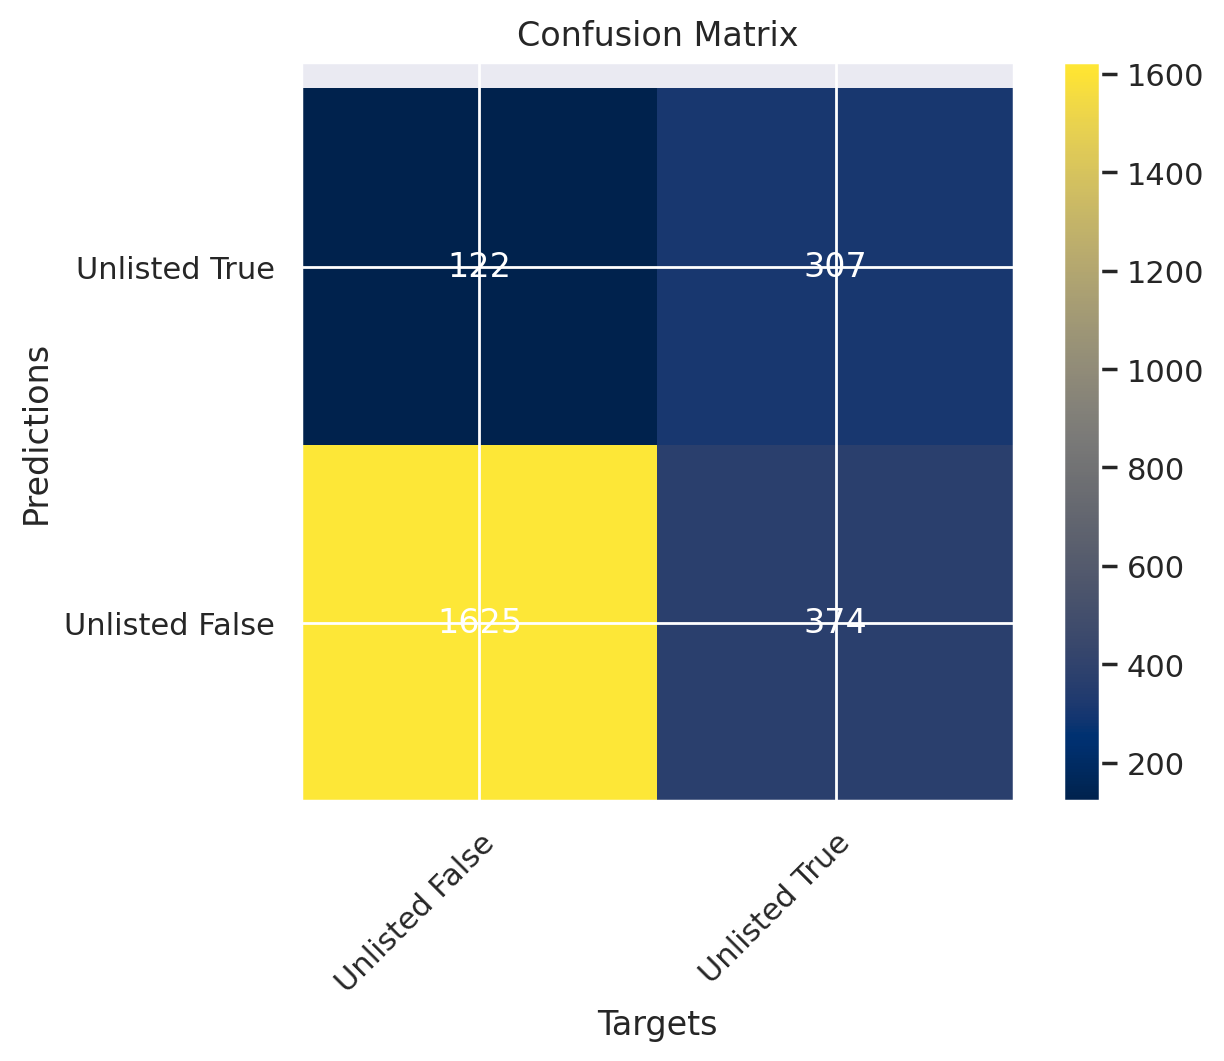

In [ ]:
plot_cm(confusion_matrix(y_pred_knn_final, y_val), labels.keys())

In [ ]:
y_pred_test = best_knn_model.predict(X_bow_test)

In [ ]:
print(y_pred_test)

[0 0 0 ... 0 0 1]


In [ ]:
test_preproc['predictions'] = y_pred_test
predictions_df = test_preproc[['index', 'predictions']].copy()

In [ ]:
# Save the DataFrame as a CSV file
predictions_df.to_csv('/content/gdrive/MyDrive/Text Mining Project/Project Corpora/Predictions_09.csv', index=False)